# Project : Registration of anatomical and functional pelvis images

Charline Curaut 3810013

### Useful libraires and functions

In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
from scipy.optimize import fsolve
from scipy.optimize import minimize
import math
import cv2
import skimage.measure 
#import imutils

In [201]:
def load_nii(difficulty, folder, f_name, verbose=0):
    
    path = 'EXAMPLE-b0-T2/' + difficulty + '/' + folder + '/' + f_name
    img = nib.load(path)
    
    if verbose > 0 :
        print(f'voxel orientation : {nib.aff2axcodes(img.affine)}')
        
    canonical_img = nib.as_closest_canonical(img)
    
    if verbose > 0 :
        print(f'voxel orientation : {nib.aff2axcodes(canonical_img.affine)}')
    
    return canonical_img.get_fdata(), canonical_img.affine

## Manipulation of data to get familiarized

Let's first put the images along the same voxel orientation.

In [410]:
minor_b0, affine_b0 = load_nii('minor', '1-2-14_off_210111', '1-2-14_off_210111_b0DWI.nii')
#print(f'image affine after canonical \n{img.affine}')
print(minor_b0.shape)

minor_T2, affine_T2 = load_nii('minor', '1-2-14_off_210111', '1-2-14_off_210111_coroT2Cube.nii')
print(minor_T2.shape)

minor_T2_mask, affine_T2_mask = load_nii('minor', '1-2-14_off_210111', '1-2-14_off_210111_T2Mask.nii')
print(minor_T2_mask.shape)

minor_Segmentation_T2, affine_T2_seg = load_nii('minor', '1-2-14_off_210111', '1-2-14_off_210111_Segmentation.nii')
print(minor_Segmentation_T2.shape)

(256, 256, 75)
(400, 179, 400)
(400, 179, 400)
(400, 179, 400)


In [4]:
print(f'b0 : {len(np.unique(minor_b0))} values in {np.unique(minor_b0)}\n')
print(f'T2 : {len(np.unique(minor_T2))} values in {np.unique(minor_T2)}\n')
print(f'T2 mask : {len(np.unique(minor_T2_mask))} values in {np.unique(minor_T2_mask)}\n')
print(f'T2 seg : {len(np.unique(minor_Segmentation_T2))} values in {np.unique(minor_Segmentation_T2)}')

b0 : 16480 values in [ 1075.  1076.  1077. ... 32457. 32560. 32767.]

T2 : 17676463 values in [0.00000000e+00 4.57295858e-35 1.13290205e-30 ... 9.91978027e+03
 9.93124707e+03 9.94759961e+03]

T2 mask : 2 values in [0. 1.]

T2 seg : 20 values in [ 0.  5.  9. 10. 14. 15. 18. 21. 24. 27. 33. 36. 42. 43. 44. 45. 49. 54.
 55. 61.]


### Visualization of a slice for each data (b0, T2 and T2_mask) (they don't necessarily correspond between one another) :

#### Axial slices

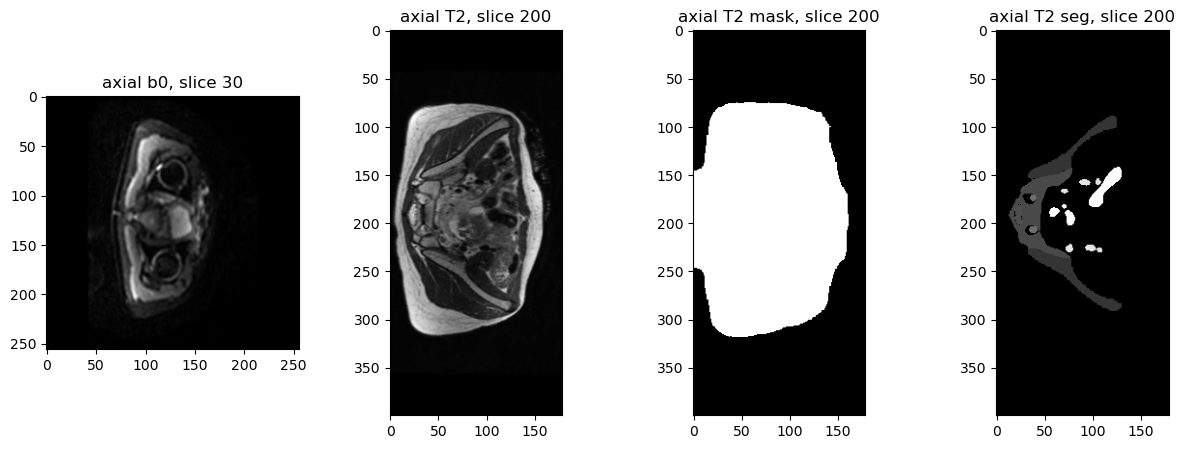

In [5]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,4,1)
axial_b0 = minor_b0[:,:,30]
plt.imshow(axial_b0, cmap="gray")
plt.title("axial b0, slice 30")

plt.subplot(1,4,2)
axial_T2 = minor_T2[:,:,200]
plt.imshow(axial_T2, cmap="gray")
plt.title("axial T2, slice 200")

plt.subplot(1,4,3)
axial_T2_mask = minor_T2_mask[:,:,200]
plt.imshow(axial_T2_mask, cmap="gray")
plt.title("axial T2 mask, slice 200")

plt.subplot(1,4,4)
axial_seg_T2 = minor_Segmentation_T2[:,:,200]
plt.imshow(axial_seg_T2, cmap="gray")
plt.title("axial T2 seg, slice 200")

plt.show()

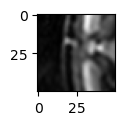

In [6]:
fig = plt.figure(figsize=(1,5))
plt.imshow(axial_b0[100:150,50:100], cmap='gray')
plt.show()

The coordinates are in RAS+ so we have (x,y,z) with x that increases to the Right, y that increases to the Anterior part, and z that increases to Superior part. Here, the images are displayed with the x axis being the vertical axis, and the y axis being the horizontal axis. 

#### Coronal slices

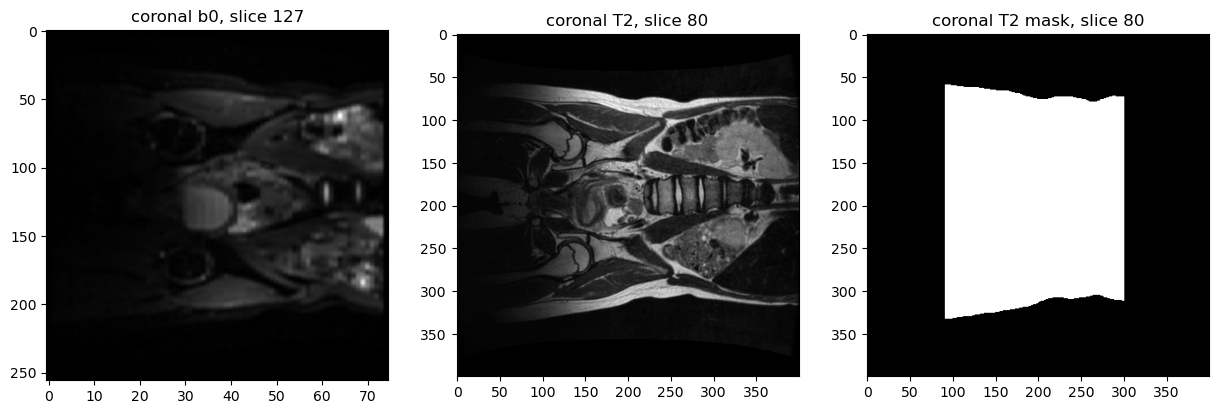

In [7]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
coronal_b0 = minor_b0[:,127,:]
plt.imshow(coronal_b0, cmap="gray")
plt.gca().set_aspect(aspect=0.3)
plt.title("coronal b0, slice 127")

plt.subplot(1,3,2)
coronal_T2 = minor_T2[:,80,:]
plt.imshow(coronal_T2, cmap="gray")
plt.title("coronal T2, slice 80")

plt.subplot(1,3,3)
coronal_T2_mask = minor_T2_mask[:,80,:]
plt.imshow(coronal_T2_mask, cmap="gray")
plt.title("coronal T2 mask, slice 80")

plt.show()

#### Sagittal slices

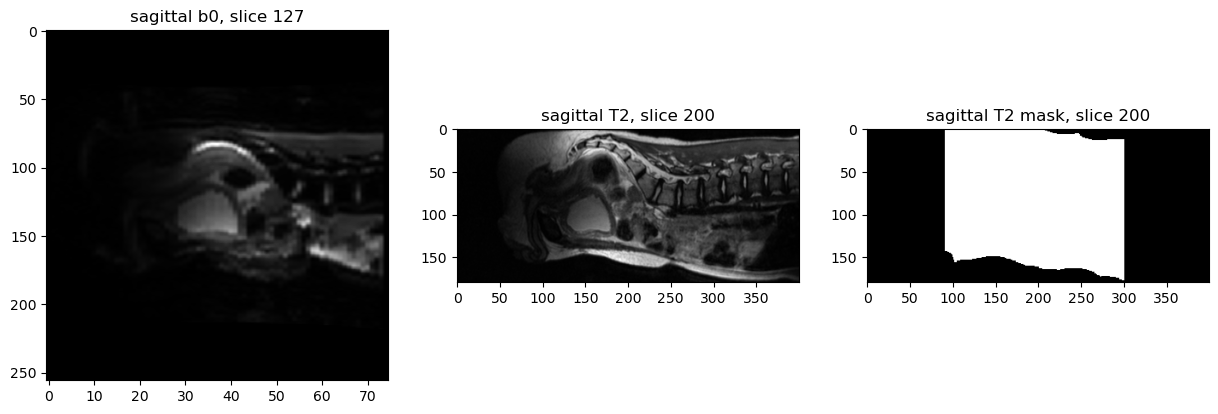

In [8]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sagittal_b0 = minor_b0[127,:,:]
plt.imshow(sagittal_b0, cmap="gray")
plt.gca().set_aspect(aspect=0.3)
plt.title("sagittal b0, slice 127")

plt.subplot(1,3,2)
sagittal_T2 = minor_T2[200,:,:]
plt.imshow(sagittal_T2, cmap="gray")
plt.title("sagittal T2, slice 200")

plt.subplot(1,3,3)
sagittal_T2_mask = minor_T2_mask[200,:,:]
plt.imshow(sagittal_T2_mask, cmap="gray")
plt.title("sagittal T2 mask, slice 200")

plt.show()

#### Cuting axial slice T2 according to given mask

In [385]:
# on manipule chaque coupe coronale pour éliminer des coupes axiales.

def cut_T2_coro(T2, T2_mask, coordinates=False) :
    """ 
    Search for each coronal slice the first and last y-coordinate pixel (which correspond to z-corrdinate voxel)
    Return a cut version of T2 (with less axial slices)
    """

    z_max = 0
    z_min = T2.shape[2]

    for i in range(T2.shape[1]) :
        slice_coro = T2[:,i,:]
        slice_coro_mask = T2_mask[:,i,:]

        for y in range(slice_coro.shape[1]) :
            if 1.0 in slice_coro_mask[:,y]:
                if y < z_min :
                    z_min = y
                break

        for y in range(slice_coro.shape[1]-1,-1,-1) :
            if 1.0 in slice_coro_mask[:,y] :
                if y > z_max :
                    z_max = y
                break
     
    if coordinates :
        return z_min, z_max

    return T2[:,:,z_min:z_max], T2_mask[:,:,z_min:z_max]

In [229]:
minor_T2_cut, minor_T2_mask_cut = cut_T2_coro(minor_T2, minor_T2_mask)
print(minor_T2_cut.shape)

(400, 179, 209)


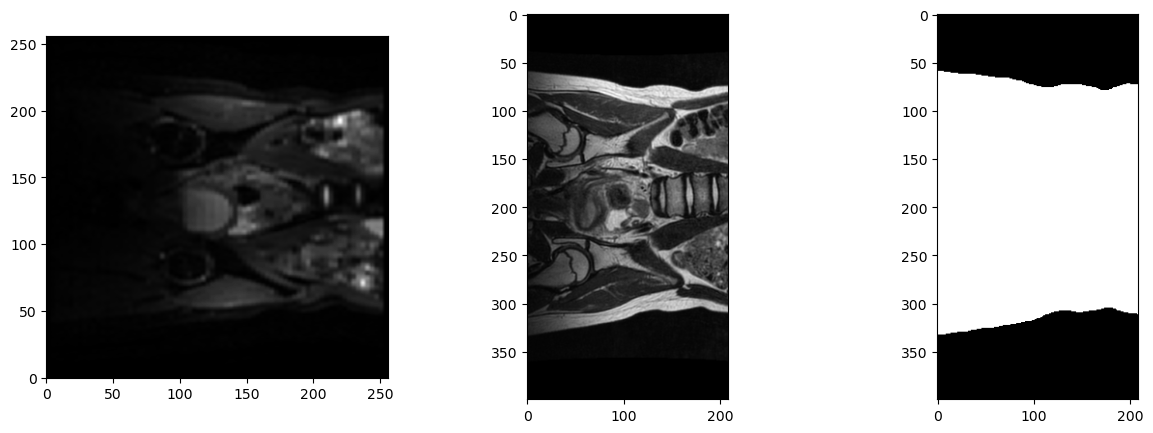

In [11]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
coronal_b0 = minor_b0[:,127,:]
plt.imshow(coronal_b0, cmap="gray", extent=(0,256,0,256))

plt.subplot(1,3,2)
coronal_T2_cut = minor_T2_cut[:,80,:]
plt.imshow(coronal_T2_cut, cmap="gray")

plt.subplot(1,3,3)
coronal_T2_mask_cut = minor_T2_mask_cut[:,80,:]
plt.imshow(coronal_T2_mask_cut, cmap="gray")

plt.show()

The function works correctly but it would be better to re-sample T2 first. In order to have the same ROI in T2 and b0, we will cut the T2 image and use the affine matrices of T2 and b0 to find cut b0 accordingly. 

#

# Pre-processing for the registration

## Resampling of T2

In [12]:
x = np.array(
    [[[0,0,4,4],[0,0,4,4],[1,1,5,5],[1,1,5,5]],
     [[0,0,4,4],[0,0,4,4],[1,1,5,5],[1,1,5,5]],
     [[2,2,6,6],[2,2,6,6],[3,3,7,7],[3,3,7,7]],
     [[2,2,6,6],[2,2,6,6],[3,3,7,7],[3,3,7,7]]] )
print(x[:,:,0])

[[0 0 1 1]
 [0 0 1 1]
 [2 2 3 3]
 [2 2 3 3]]


In [13]:
resample_x0_5 = scipy.ndimage.zoom(x, (0.5, 0.5, 0.5), order=1)
#print(resample_x0_5)
print(resample_x0_5[:,:,0])

[[0 1]
 [2 3]]


In [411]:
## voxel size T2 : 0.88 mm x 0.85 mm x 0.88 mm
## voxel size b0 : 1.25 mm x 1.25 mm x 3.5 mm

scale_sagittal = 0.88 / 1.25
scale_coronal = 0.85 / 1.25
scale_axial = 0.88 / 3.5

print(f'sagittal scale = {scale_sagittal}')
print(f'coronal scale = {scale_coronal}')
print(f'axial scale = {scale_axial}\n')

tmp_T2 = minor_T2.copy()
tmp_T2_mask = minor_T2_mask.copy()


print(f'T2 size before re-sampling :\t{tmp_T2.shape} voxels\t{tuple(np.array(tmp_T2.shape) * [0.88, 0.85, 0.88])} mm')
resampled_T2 = scipy.ndimage.zoom(tmp_T2, (scale_sagittal, scale_coronal, scale_axial), order=1)
print(f'T2 size after re-sampling :\t{resampled_T2.shape} voxels\t{tuple(np.array(resampled_T2.shape) * [1.25, 1.25, 3.5])} mm\n')

print(f'mask T2 size before re-sampling :\t{tmp_T2_mask.shape} voxels\t{tuple(np.array(tmp_T2_mask.shape) * [0.88, 0.85, 0.88])} mm')
resampled_T2_mask = scipy.ndimage.zoom(tmp_T2_mask, (scale_sagittal, scale_coronal, scale_axial), order=1)
print(f'mask T2 size after re-sampling :\t{resampled_T2_mask.shape} voxels\t{tuple(np.array(resampled_T2_mask.shape) * [1.25, 1.25, 3.5])} mm\n')

print(f'b0 size : \t{minor_b0.shape} voxels \t{tuple(np.array(minor_b0.shape) * [1.25, 1.25, 3.5])} mm')

sagittal scale = 0.704
coronal scale = 0.6799999999999999
axial scale = 0.25142857142857145

T2 size before re-sampling :	(400, 179, 400) voxels	(352.0, 152.15, 352.0) mm
T2 size after re-sampling :	(282, 122, 101) voxels	(352.5, 152.5, 353.5) mm

mask T2 size before re-sampling :	(400, 179, 400) voxels	(352.0, 152.15, 352.0) mm
mask T2 size after re-sampling :	(282, 122, 101) voxels	(352.5, 152.5, 353.5) mm

b0 size : 	(256, 256, 75) voxels 	(320.0, 320.0, 262.5) mm


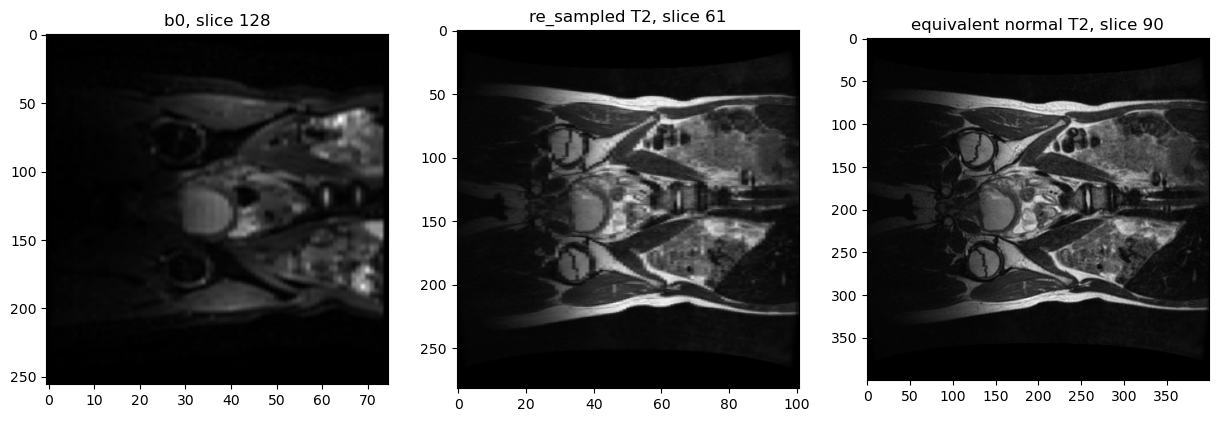

In [412]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
coronal_b0 = minor_b0[:,128,:]
plt.imshow(coronal_b0, cmap="gray")
plt.gca().set_aspect(aspect=0.3)
plt.title("b0, slice 128")

plt.subplot(1,3,2)
coronal_resampled_T2 = resampled_T2[:,61,:]
plt.imshow(coronal_resampled_T2, cmap="gray")
plt.gca().set_aspect(aspect=0.375)
plt.title("re_sampled T2, slice 61")

plt.subplot(1,3,3)
coronal_T2 = minor_T2[:,90,:]
plt.imshow(coronal_T2, cmap="gray")
plt.title("equivalent normal T2, slice 90")

plt.show()

## Region of interest (automated with mask)

In [413]:
minor_T2_cut, minor_T2_mask_cut = cut_T2_coro(resampled_T2, resampled_T2_mask)
print(resampled_T2.shape)
print(minor_T2_cut.shape)
#plt.imshow(minor_T2_cut[:,61,:], cmap='gray')
#plt.gca().set_aspect(aspect=0.375)

(282, 122, 101)
(282, 122, 52)


In [414]:
print([2,3,4] * np.identity(3))

[[2. 0. 0.]
 [0. 3. 0.]
 [0. 0. 4.]]


In [415]:
## To automate with the affine matrix, we need to modify that of T2 because we resampled it
print(f'affine of original T2 : \n{affine_T2}')
M = affine_T2[0:3,0:3]
T = affine_T2[0:3,3]

## it's like doing a transformation then rescaling
## so we just have to multiply by the scaling factor
zooming_matrix = [1./scale_sagittal, 1./scale_coronal, 1./scale_axial] * np.identity(3) 
M = np.dot(M,zooming_matrix)

affine_T2_resampled = np.zeros_like(affine_T2)
affine_T2_resampled[0:3,0:3] = M
affine_T2_resampled[0:3,3] = T
affine_T2_resampled[3,3] = 1
print(f'affine of resampled T2 : \n{affine_T2_resampled}')

affine of original T2 : 
[[   0.88          0.           -0.         -175.97200012]
 [   0.            0.85000002   -0.          -91.72620392]
 [   0.            0.            0.88       -225.76399231]
 [   0.            0.            0.            1.        ]]
affine of resampled T2 : 
[[   1.24999999    0.            0.         -175.97200012]
 [   0.            1.25000004    0.          -91.72620392]
 [   0.            0.            3.49999998 -225.76399231]
 [   0.            0.            0.            1.        ]]


In [416]:
## transforming the voxel coordinates (T2) to RAS coordinates via affine matrix to have z_min and z_max (to cut coronal slices)

z_min_resampled_T2, z_max_resampled_T2 = cut_T2_coro(resampled_T2, resampled_T2_mask, coordinates=True)
print(f'resampled T2 : z_min = {z_min_resampled_T2} and z_max = {z_max_resampled_T2}') ## result coherent with previous cut (decomment imshow of "region of interest")

(_,_,z_min_RAS,_) = np.dot(affine_T2_resampled,(0, 0, z_min_resampled_T2,1))
(_,_,z_max_RAS,_) = np.dot(affine_T2_resampled,(0, 0, z_max_resampled_T2,1))

print(f'RAS : corresponding z_min = {z_min_RAS} and z_max = {z_max_RAS}') ## coherent result

resampled T2 : z_min = 23 and z_max = 75
RAS : corresponding z_min = -145.26399274576795 and z_max = 36.73600626804608


In [417]:
## transforming founded z_min and z_max to RAS coordinates to voxel coordinates (b0) to cut coronal slices

inverse_affine_b0 = np.linalg.inv(affine_b0)
(_,_,z_min_b0,_) = np.dot(inverse_affine_b0, (0,0,z_min_RAS,1))
(_,_,z_max_b0,_) = np.dot(inverse_affine_b0, (0,0,z_max_RAS,1))
print(f' b0 : z_min = {z_min_b0} and z_max = {z_max_b0}')
z_min_b0 = int(np.rint(z_min_b0))
z_max_b0 = int(np.rint(z_max_b0))
print(f' b0 : rounded z_min = {z_min_b0} and rounded z_max = {z_max_b0}')

 b0 : z_min = 19.109387150541536 and z_max = 71.10935918080328
 b0 : rounded z_min = 19 and rounded z_max = 71


These results are quite coherent. Both images now have the same voxel size and after the cut, they have the same number of axial slices with $75 - 23 = 52$ slices for T2 and $71 - 19 = 52$ slices for b0 (we just need to round the result for b0). 

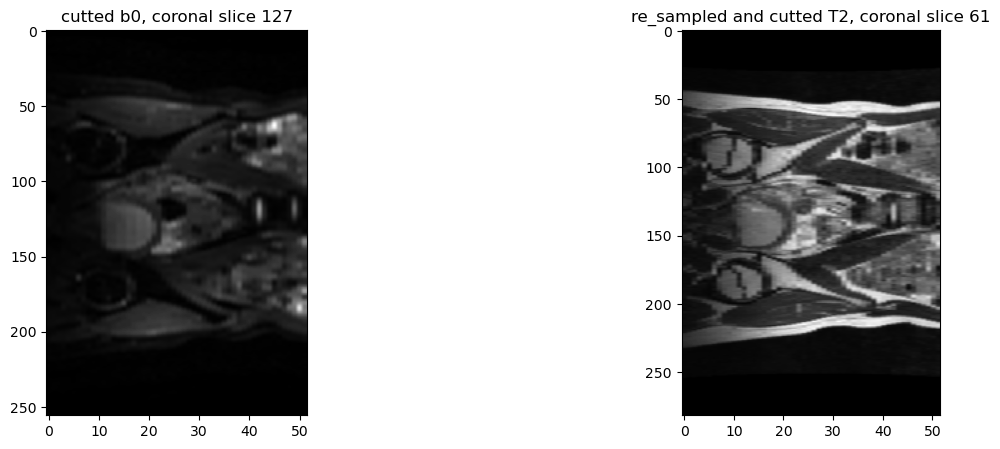

In [418]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
coronal_b0_cut = minor_b0[:,127,z_min_b0:z_max_b0]
plt.imshow(coronal_b0_cut, cmap='gray')
plt.gca().set_aspect(aspect=0.3)

plt.title("cutted b0, coronal slice 127")

plt.subplot(1,2,2)
coronal_resampled_T2_cut = resampled_T2[:,61,z_min_resampled_T2:z_max_resampled_T2]
plt.imshow(coronal_resampled_T2_cut, cmap="gray")
plt.gca().set_aspect(aspect=0.275)
plt.gca().xaxis.set_ticks([0, 10, 20, 30, 40, 50])
plt.title("re_sampled and cutted T2, coronal slice 61")

plt.show()

In [419]:
print(f'cutted b0 shape : {minor_b0[:,:,z_min_b0:z_max_b0].shape}')
print(f'cutted and re_sampled T2 shape : {resampled_T2[:,:,z_min_resampled_T2:z_max_resampled_T2].shape}')

cutted b0 shape : (256, 256, 52)
cutted and re_sampled T2 shape : (282, 122, 52)


## Padding 

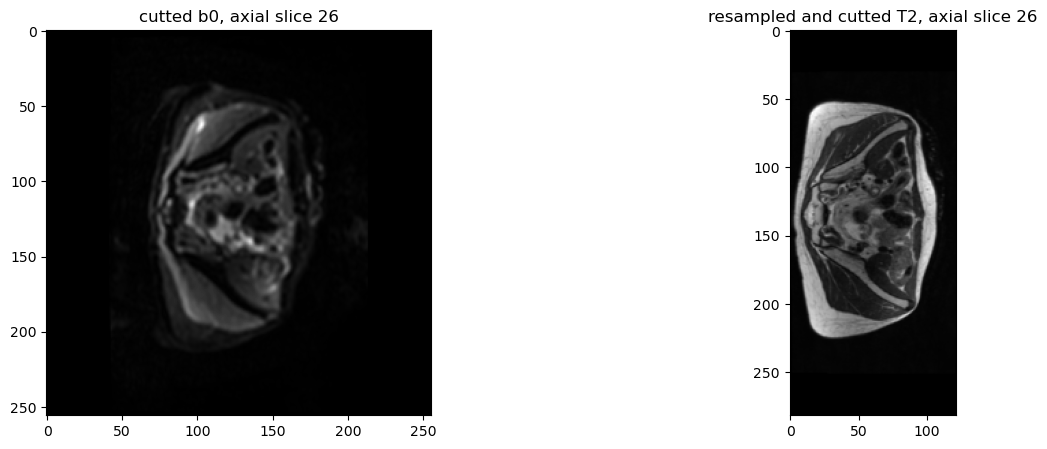

In [420]:
### Axial slices
## Here are the first two images we'll try to register

minor_b0_cut = minor_b0[:,:,z_min_b0:z_max_b0]
minor_resampled_T2_cut = resampled_T2[:,:,z_min_resampled_T2:z_max_resampled_T2]

fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
axial_b0_cut_23 = minor_b0_cut[:,:,26]
plt.imshow(axial_b0_cut_23, cmap='gray')
plt.title("cutted b0, axial slice 26")

plt.subplot(1,2,2)
axial_resampled_T2_cut_23 = minor_resampled_T2_cut[:,:,26]
plt.imshow(axial_resampled_T2_cut_23, cmap="gray")
plt.title("resampled and cutted T2, axial slice 26")

plt.show()

In [465]:
def padding(img1, img2) :
    """
    Padding img1 and/or img2 to have same shape (object is centered)
    """
    
    tmp1 = img1.copy()
    tmp2 = img2.copy()
    h1, w1 = img1.shape
    h2, w2 = img2.shape
    pad_h = h2-h1
    pad_w = w2-w1
    
    
    if pad_h < 0 :
        ## h2 < h1
        if pad_h % 2 == 0 :
            pad_h = np.abs(pad_h)//2
            tmp = np.vstack(( np.zeros((pad_h,w2)), tmp2, np.zeros((pad_h,w2)) ))
        else :
            pad_h = (np.abs(pad_h) + 1) // 2
            tmp = np.vstack(( np.zeros((pad_h,w2)), tmp2, np.zeros((pad_h-1,w2)) ))
            
        if pad_w < 0 :
            ## w2 < w1
            if pad_w % 2 == 0 :
                pad_w = np.abs(pad_w)//2
                nv_img2 = np.hstack(( np.zeros((tmp.shape[0],pad_w)), tmp, np.zeros((tmp.shape[0],pad_w)) ))
            else :
                pad_w = (np.abs(pad_w) + 1) // 2
                nv_img2 = np.hstack(( np.zeros((tmp.shape[0],pad_w)), tmp, np.zeros((tmp.shape[0],pad_w-1)) ))
                
            return tmp1, nv_img2
        
        elif pad_w == 0 :
            return tmp1, tmp
        
        else :
            ## w2 > w1
            if pad_w % 2 == 0 :
                pad_w = np.abs(pad_w)//2
                nv_img1 = np.hstack(( np.zeros((h1,pad_w)), tmp1, np.zeros((h1,pad_w)) ))
            else :
                pad_w = (np.abs(pad_w) + 1) // 2
                nv_img1 = np.hstack(( np.zeros((h1,pad_w)), tmp1, np.zeros((h1,pad_w-1)) ))
                
            return nv_img1, tmp
        
    elif pad_h == 0 :
        if pad_w < 0 :
            ## w2 < w1
            if pad_w % 2 == 0 :
                pad_w = np.abs(pad_w)//2
                nv_img2 = np.hstack(( np.zeros((h2,pad_w)), tmp2, np.zeros((h2,pad_w)) ))
            else :
                pad_w = (np.abs(pad_w) + 1) // 2
                nv_img2 = np.hstack(( np.zeros((h2,pad_w)), tmp2, np.zeros((h2,pad_w-1)) ))
                
            return tmp1, nv_img2
        
        elif pad_w == 0 :
            return tmp1, tmp
        
        else :
            ## w2 > w1
            if pad_w % 2 == 0 :
                pad_w = np.abs(pad_w)//2
                nv_img1 = np.hstack(( np.zeros((h1,pad_w)), tmp1, np.zeros((h1,pad_w)) ))
            else :
                pad_w = (np.abs(pad_w) + 1) // 2
                nv_img1 = np.hstack(( np.zeros((h1,pad_w)), tmp1, np.zeros((h1,pad_w-1)) ))
                
            return nv_img1, tmp2
        
    else :
        ## h2 > h1
        if pad_h % 2 == 0 :
            pad_h = np.abs(pad_h)//2
            tmp = np.vstack(( np.zeros((pad_h,w1)), tmp1, np.zeros((pad_h,w1)) ))
        else :
            pad_h = (np.abs(pad_h) + 1) // 2
            tmp = np.vstack(( np.zeros((pad_h,w1)), tmp1, np.zeros((pad_h-1,w1)) ))
        
        if pad_w < 0 :
            ## w2 < w1
            if pad_w % 2 == 0 :
                pad_w = np.abs(pad_w)//2
                nv_img2 = np.hstack(( np.zeros((h2,pad_w)), tmp2, np.zeros((h2,pad_w)) ))
            else :
                pad_w = (np.abs(pad_w) + 1) // 2
                nv_img2 = np.hstack(( np.zeros((h2,pad_w)), tmp2, np.zeros((h2,pad_w-1)) ))
                
            return tmp, nv_img2
        
        elif pad_w == 0 :
            return tmp, tmp2
        
        else :
            ## w2 > w1
            if pad_w % 2 == 0 :
                pad_w = np.abs(pad_w)//2
                nv_img1 = np.hstack(( np.zeros((tmp.shape[0],pad_w)), tmp, np.zeros((tmp.shape[0],pad_w)) ))
            else :
                pad_w = (np.abs(pad_w) + 1) // 2
                nv_img1 = np.hstack(( np.zeros((tmp.shape[0],pad_w)), tmp, np.zeros((tmp.shape[0],pad_w-1)) ))
                
            return nv_img1, tmp2

    

(282, 256)


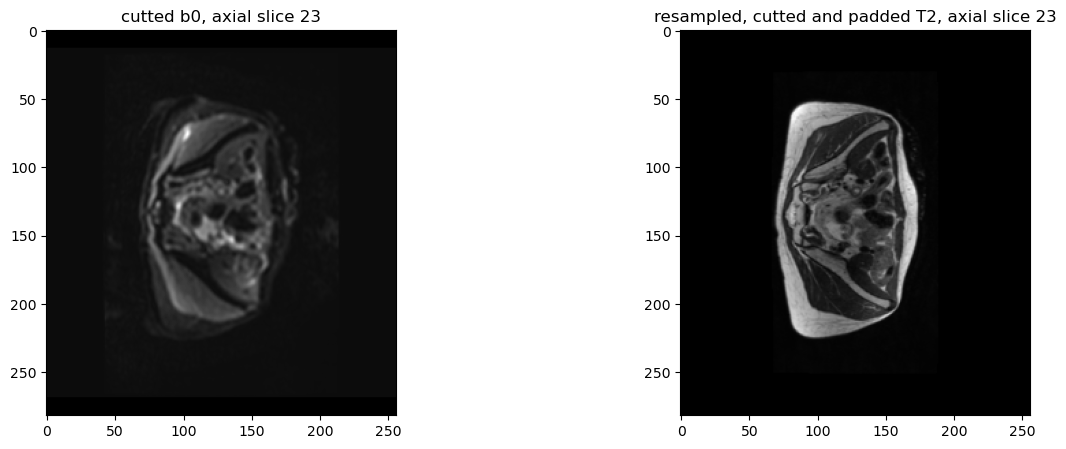

In [422]:
## padding T2 to have same size as b0
axial_resampled_T2_cut_pad_23, axial_b0_cut_pad_23 = padding(axial_resampled_T2_cut_23, axial_b0_cut_23)
print(axial_resampled_T2_cut_pad_23.shape)

fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.imshow(axial_b0_cut_pad_23, cmap='gray')
plt.title("cutted b0, axial slice 23")

plt.subplot(1,2,2)
plt.imshow(axial_resampled_T2_cut_pad_23, cmap="gray")
plt.title("resampled, cutted and padded T2, axial slice 23")

plt.show()

#

# 2D-2D registration

Mutual Information I for images A and B : I(A,B) = H(A) + H(B) - H(A,B) where H is Shannon entropy.
Shannon entropy --> scipy.stats.entropy(pk) where pk is the probability distribution.

## Joint entropy 

[[6656.    0.    0. ...    0.    0.    0.]
 [   0.    0.    0. ...    0.    0.    0.]
 [   0.    0.    0. ...    0.    0.    0.]
 ...
 [   0.    0.    0. ...    0.    0.    0.]
 [   0.    0.    0. ...    0.    0.    0.]
 [   0.    0.    0. ...    0.    0.    0.]]


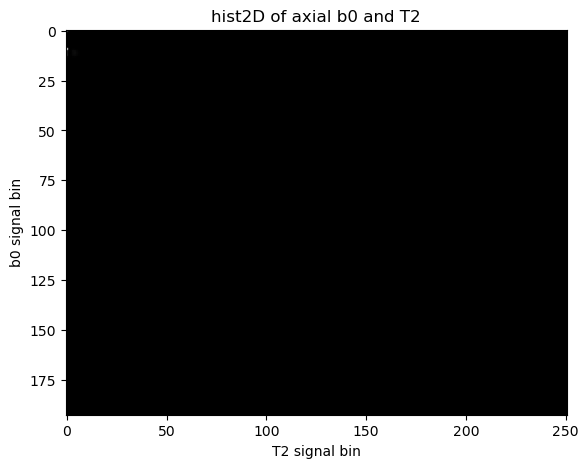

In [32]:
## The number of gray values are too high so we will normalize allt he images 
## (to have values between 0 and 255) to make the registration faster

axial_resampled_T2_cut_pad_norm_23 = cv2.normalize(axial_resampled_T2_cut_pad_23, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
axial_b0_cut_pad_norm_23 = cv2.normalize(axial_b0_cut_pad_23, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

#hist_b0_T2_0, xedges, yedges = np.histogram2d(axial_resampled_T2_cut_pad_23.ravel(), axial_b0_cut_pad_23.ravel(), bins=[len(np.unique(axial_resampled_T2_cut_pad_23)),len(np.unique(axial_b0_cut_23))])
hist_b0_T2_0, _, _ = np.histogram2d(axial_resampled_T2_cut_pad_norm_23.ravel(), axial_b0_cut_pad_norm_23.ravel(), bins=[len(np.unique(axial_resampled_T2_cut_pad_norm_23)),len(np.unique(axial_b0_cut_pad_norm_23))])

print(hist_b0_T2_0)
#print(xedges)
#print(yedges)


fig = plt.figure(figsize=(10,5))

plt.imshow(hist_b0_T2_0.T, cmap='gray')
plt.title("hist2D of axial b0 and T2")
plt.xlabel("T2 signal bin")
plt.ylabel("b0 signal bin")

plt.show()


In [33]:
print(np.unique(hist_b0_T2_0))

[0.0000e+00 1.0000e+00 2.0000e+00 3.0000e+00 4.0000e+00 5.0000e+00
 6.0000e+00 7.0000e+00 8.0000e+00 9.0000e+00 1.0000e+01 1.1000e+01
 1.2000e+01 1.3000e+01 1.4000e+01 1.5000e+01 1.6000e+01 1.7000e+01
 1.8000e+01 1.9000e+01 2.2000e+01 2.3000e+01 2.4000e+01 2.5000e+01
 2.6000e+01 2.7000e+01 2.8000e+01 3.1000e+01 3.2000e+01 3.5000e+01
 3.6000e+01 3.8000e+01 3.9000e+01 4.4000e+01 4.5000e+01 4.7000e+01
 5.1000e+01 5.8000e+01 5.9000e+01 6.2000e+01 6.4000e+01 7.4000e+01
 7.7000e+01 8.1000e+01 1.0500e+02 1.1700e+02 1.2100e+02 1.2400e+02
 1.3100e+02 1.3900e+02 1.4000e+02 1.7400e+02 1.7900e+02 1.8200e+02
 3.5300e+02 4.0400e+02 4.4300e+02 4.5500e+02 6.1400e+02 7.7500e+02
 7.9800e+02 9.0000e+02 9.5200e+02 1.0060e+03 1.0190e+03 1.2570e+03
 3.3570e+03 3.5670e+03 3.9190e+03 6.6560e+03 2.5856e+04]


The 2D histogram is actually not completely black

[[8.80327398 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


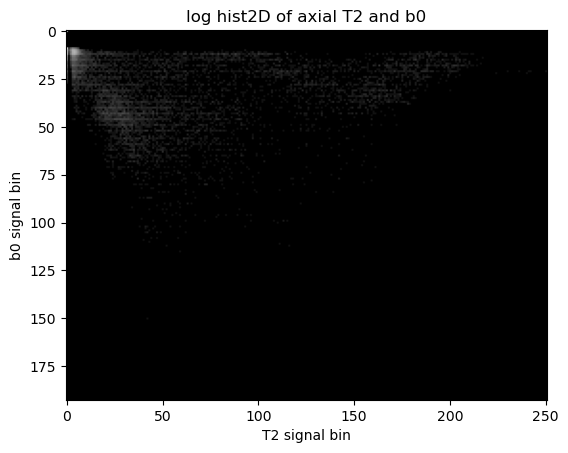

In [34]:
## trying to better see the results (to better differenciate the pixels different from zero) 
## --> This cell is not usefull if the images were not normalized before. The resolution will still
## be to small, we won't distinguish any pixels in the large matrix

hist_b0_T2_0_log = np.zeros(hist_b0_T2_0.shape)
non_zeros = hist_b0_T2_0 != 0
hist_b0_T2_0_log[non_zeros] = np.log(hist_b0_T2_0[non_zeros])

plt.imshow(hist_b0_T2_0_log.T, cmap='gray')
plt.title("log hist2D of axial T2 and b0")
plt.xlabel('T2 signal bin')
plt.ylabel('b0 signal bin')

print(hist_b0_T2_0_log)

entropy img1 :  3.2988304538531685
entropy img2 :  3.2988304538531685
entropy jointe :  3.290814830930452
nmi between 90 and 90 : 3.306846076775885

entropy img1 :  3.2988304538531685
entropy img2 :  3.2988304538531685
entropy jointe :  5.147840234267948
nmi between 90 and a : 1.4498206734383894

entropy img1 :  3.2988304538531685
entropy img2 :  3.2988304538531685
entropy jointe :  5.501146960067962
nmi between 90 and b : 1.0965139476383747



Text(0, 0.5, 'b0 signal bin')

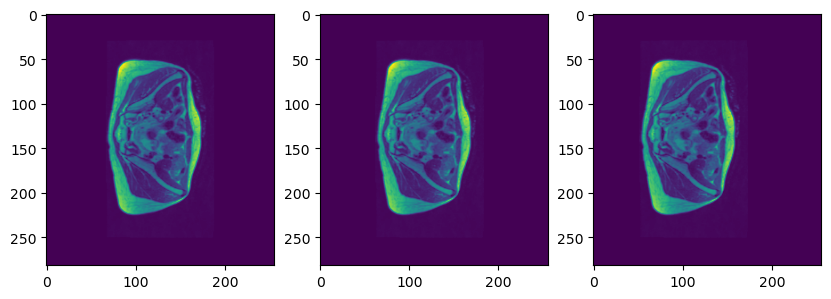

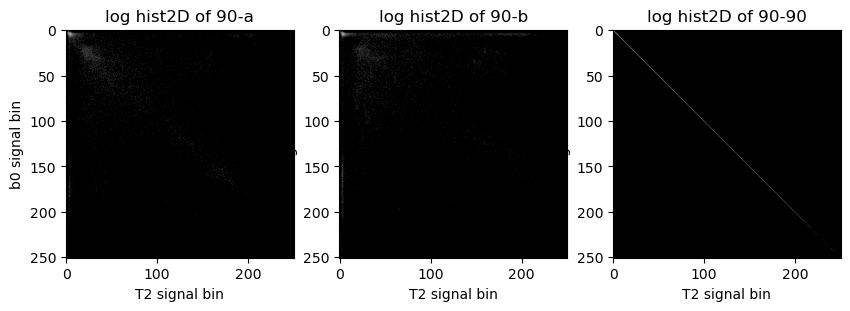

In [53]:
rotation_90 = transform_image_translation([0,0],axial_resampled_T2_cut_pad_norm_23)
rotation_a = transform_image_translation([-5,0],axial_resampled_T2_cut_pad_norm_23)
rotation_b = transform_image_translation([-15,0],axial_resampled_T2_cut_pad_norm_23)
#rotation_a = transform_image_rotation(1,rotation_90)
#rotation_b = transform_image_rotation(5,rotation_90)

plt.figure(figsize=(10,20))
plt.subplot(1,3,1)
plt.imshow(rotation_90)
plt.subplot(1,3,2)
plt.imshow(rotation_a)
plt.subplot(1,3,3)
plt.imshow(rotation_b)

print(f'nmi between 90 and 90 : {mutual_information(rotation_90, rotation_90, verbose=1)}\n')
print(f'nmi between 90 and a : {mutual_information(rotation_90, rotation_a, verbose=1)}\n')
print(f'nmi between 90 and b : {mutual_information(rotation_90, rotation_b, verbose=1)}\n')

joint_hist_90_a, _, _ = np.histogram2d(rotation_90.ravel(), rotation_a.ravel(), bins=[len(np.unique(rotation_90)),len(np.unique(rotation_a))])
joint_hist_90_a_log = np.zeros(joint_hist_90_a.shape)
non_zeros = joint_hist_90_a != 0
joint_hist_90_a_log[non_zeros] = np.log(joint_hist_90_a[non_zeros])

joint_hist_90_b, _, _ = np.histogram2d(rotation_90.ravel(), rotation_b.ravel(), bins=[len(np.unique(rotation_90)),len(np.unique(rotation_b))])
joint_hist_90_b_log = np.zeros(joint_hist_90_b.shape)
non_zeros = joint_hist_90_b != 0
joint_hist_90_b_log[non_zeros] = np.log(joint_hist_90_b[non_zeros])

joint_hist_90_90, _, _ = np.histogram2d(rotation_90.ravel(), rotation_90.ravel(), bins=[len(np.unique(rotation_90)),len(np.unique(rotation_90))])
joint_hist_90_90_log = np.zeros(joint_hist_90_90.shape)
non_zeros = joint_hist_90_90 != 0
joint_hist_90_90_log[non_zeros] = np.log(joint_hist_90_90[non_zeros])

plt.figure(figsize=(10,20))
plt.subplot(1,3,1)
plt.imshow(joint_hist_90_a_log.T, cmap='gray')
plt.title("log hist2D of 90-a")
plt.xlabel('T2 signal bin')
plt.ylabel('b0 signal bin')

plt.subplot(1,3,2)
plt.imshow(joint_hist_90_b_log.T, cmap='gray')
plt.title("log hist2D of 90-b")
plt.xlabel('T2 signal bin')
plt.ylabel('b0 signal bin')

plt.subplot(1,3,3)
plt.imshow(joint_hist_90_90_log.T, cmap='gray')
plt.title("log hist2D of 90-90")
plt.xlabel('T2 signal bin')
plt.ylabel('b0 signal bin')

## Mutual information

In [40]:
# Mutual information function (using skimage.measure.shannon_entropy)

def mutual_information(img1, img2, verbose=0):
    
    # Calculate joint histogram
    joint_hist, _, _ = np.histogram2d(img1.ravel(), img2.ravel(), bins=[len(np.unique(img1)),len(np.unique(img2))])    
    joint_hist /= np.sum(joint_hist)
    joint_dist = joint_hist.ravel()
    
    # Shannon entropy for each distribution
    H_img1 = skimage.measure.shannon_entropy(img1)
    H_img2 = skimage.measure.shannon_entropy(img2)
    H_joint = scipy.stats.entropy(joint_dist, base=2)
    
    if verbose > 0 : 
        print("entropy img1 : ", H_img1)
        print("entropy img2 : ", H_img2)
        print("entropy jointe : ", H_joint)
    

    # Calculate mutual information
    if H_joint == 0 :
        mi = H_img1 + H_img2
    else : 
        mi = (H_img1 + H_img2) - H_joint
        
    #print(mi)
    
    return mi  


In [54]:
### Property of mutual information : MI(A,A) = H(A)   ---> OK  
MI = mutual_information(rotation_b, rotation_b, verbose=1)
print(f'\nMI between rotation_b and rotation_b : {MI}')
dist_b = image_distribution(rotation_b)
print(f'Shannon entropy of rotation_b : {scipy.stats.entropy(dist_b, base=2)}')

entropy img1 :  3.2988304538531685
entropy img2 :  3.2988304538531685
entropy jointe :  3.290814830930452

MI between rotation_b and rotation_b : 3.306846076775885
Shannon entropy of rotation_b : 3.2988304538531685


In [55]:
### Property of mutual information : MI(A,B) = MI(B,A)  ---> OK

print(f'MI between rotation_90 and rotation_b : {mutual_information(rotation_90, rotation_b)}')
print(f'MI between rotation_b and rotation_90 : {mutual_information(rotation_b, rotation_90)}')


MI between rotation_90 and rotation_b : 1.0965139476383747
MI between rotation_b and rotation_90 : 1.0965139476383747


In [56]:
### Property of mutual information : MI(A,B) <= H(A) and MI(A,B) <= H(B) --> OK

print(f'MI between rotation_90 and b0 : {mutual_information(rotation_90, axial_b0_cut_pad_norm_23, verbose=1)}')

entropy img1 :  3.2988304538531685
entropy img2 :  4.063769381315207
entropy jointe :  6.139925641509074
MI between rotation_90 and b0 : 1.2226741936593006


## Gradient descent algorithm

Translation and rotation loops are separated 

In [46]:
# Define transformation function for translation only 

def transform_image_translation(params, img):
    rows, cols = img.shape
    dx, dy= params
    #print(f'dx: {dx}, dy: {dy}')

    M = np.float32([[1, 0, dx], [0, 1, dy], [0, 0, 1]])
    M_inv = np.linalg.inv(M)[0:2,0:3]
    
    return cv2.warpAffine(img.copy(), M_inv, (cols, rows), flags=cv2.INTER_NEAREST + cv2.WARP_INVERSE_MAP)

In [47]:
def transform_image_rotation(theta, img):
    rows, cols = img.shape
    
    M = cv2.getRotationMatrix2D((cols/2, rows/2), theta, 1)
    M = np.vstack((M,[0,0,1]))
    M_inv = np.linalg.inv(M)[0:2,0:3]
    
    return cv2.warpAffine(img.copy(), M_inv, (cols, rows), flags= cv2.INTER_NEAREST + cv2.WARP_INVERSE_MAP)

In [48]:
# Define your cost function for optimization, translation only

def cost_function_translation(params, img1, img2):
    transformed_img = transform_image_translation(params, img1)
    return mutual_information(transformed_img, img2)

In [49]:
# Define your cost function for optimization, rotation only

def cost_function_rotation(theta, img1, img2):
    transformed_img = transform_image_rotation(theta, img1)
    return mutual_information(transformed_img, img2)

In [50]:
# Gradient calculation for the cost function for translation only

def gradient_translation(params, img1, img2, epsilon=[5.,5.], verbose=0):
    ## Calculate gradient for each param
    grad = np.zeros_like(params)
    
    for i in range(len(params)):
        params_pos = params.copy()
        params_neg = params.copy()
        params_pos[i] += epsilon[i]
        params_neg[i] -= epsilon[i]
        delta = 2 * epsilon[i]
        
        cost_pos = cost_function_translation(params_pos, img1, img2)
        cost_neg = cost_function_translation(params_neg, img1, img2)
        
        if verbose > 0 :
            print(f'\nparams_pos : {params_pos[i]}, params_neg : {params_neg[i]}')
            print(f'for grad_{i}\ncost_pos : {cost_pos}, cost_neg : {cost_neg}, delta : {delta}')
            print(f'grad = {(cost_pos - cost_neg) / delta}')
        
        grad[i] = (cost_pos - cost_neg) / delta
        
    return grad


In [51]:
# Gradient calculation for the cost function for rotation only

def gradient_rotation(theta, img1, img2, epsilon=5., verbose=0):
    ## Calculate gradient for each param
    grad = 0
    
    param_pos = theta + epsilon
    param_neg = theta - epsilon
    delta = 2 * epsilon
        
    cost_pos = cost_function_rotation(param_pos, img1, img2)
    cost_neg = cost_function_rotation(param_neg, img1, img2)
        
    if verbose > 0 :
        print(f'cost_pos : {cost_pos}, cost_neg : {cost_neg}, delta : {delta}')
        print(f'grad = {(cost_pos - cost_neg) / delta}')
        
    grad = (cost_pos - cost_neg) / delta
        
    return grad


In [323]:
# Gradient descent optimization for translation only

def gradient_descent_translation(cost_func, grad_func, initial_params, img1, img2, learning_rate=[100.,100.], max_iters=100, verbose=0):
    params = initial_params.copy()
    epsilon = 1e-3
    alpha = 5.
    
    for i in range(max_iters):
        
        ## reducing alpha (epsilon in the gradient functions) and epsilon (stop condition)
        if (i % 10 == 0) and i != 0:
            learning_rate[0] *= 0.95
            learning_rate[1] *= 0.95
            alpha *= 0.9
            #print(f'\nalpha = {alpha}\n')
        
        grads = grad_func(params, img1, img2, epsilon=[alpha,alpha])
        #print(f'translation grads = {grads}')
    
    
        ## Stop condition 
        if (np.abs(grads[0]) < epsilon) and (np.abs(grads[1]) < epsilon) :
        #if np.abs(learning_rate[0] * grads[0]) <= epsilon and np.abs(learning_rate[1] * grads[1]) <= epsilon :
            cost = cost_func(params, img1, img2)
            #print(f'd0 = {d0}, grads[0]*etha = {learning_rate[0] * grads[0]}')
            #print(f'd1 = {d1}, grads[1]*etha = {learning_rate[1] * grads[1]}')
            if verbose > 0 :
                print(f"STOP : Iteration {i}: Cost = {cost}, translation_params = {params}")
            return params
            
        
        ## eliminating the tiny gradients
        if np.abs(grads[0]) < epsilon :
        #if np.abs(learning_rate[0] * grads[0]) <= epsilon :
            d0 = 0
        else :
            d0 = learning_rate[0] * grads[0]
            ## forcing the algorithm to do something (to overcome the little gradients at the beginning)
            #if grads[0] > 0 :
            #    d0 = np.ceil(learning_rate[0] * grads[0])
            #else :
            #    d0 = np.floor(learning_rate[0] * grads[0])
                
        if np.abs(grads[1]) < epsilon :
        #if np.abs(learning_rate[1] * grads[1]) <= epsilon :
            d1 = 0
        else :
            d1 = learning_rate[1] * grads[1]
            #if grads[1] > 0 :
            #    d1 = np.ceil(learning_rate[1] * grads[1])
            #else :
            #    d1 = np.floor(learning_rate[1] * grads[1])
                
        
        #print(f'd0 = {d0}, gradient0 = {grads[0]}')
        #print(f'd1 = {d1}, gradient1 = {grads[1]}')    
        #print(f'd0 = {d0}, grads[0]*etha = {learning_rate[0] * grads[0]}')
        #print(f'd1 = {d1}, grads[1]*etha = {learning_rate[1] * grads[1]}\n')

        
        #d0 = np.rint(learning_rate[0] * grads[0])
        #d1 = np.rint(learning_rate[1] * grads[1])
        
        #d0 = learning_rate[0] * np.sign(grads[0])  ### learning_rate = 1.
        #d1 = learning_rate[1] * np.sign(grads[1])  ### epsilon = 5e-3
        
        params[0] += d0
        params[1] += d1

        
        # Print the cost every few iterations
        if verbose > 0 and i % 10 == 0:
            cost = cost_func(params, img1, img2)
            print(f"Iteration {i}: Cost = {cost}, translation_params = {params}")
    
    return params

In [324]:
# Gradient descent optimization for rotation only

def gradient_descent_rotation(cost_func, grad_func, initial_theta, img1, img2, learning_rate=100., max_iters=101, verbose=0):
    epsilon = 1e-3
    
    for i in range(max_iters):
        grad = grad_func(initial_theta, img1, img2)
        
        
        # STOP condition
        if np.round(np.abs(grad),3) <= epsilon :
            cost = cost_func(initial_theta, img1, img2)
            if verbose > 0 :
                print(f"STOP : Iteration {i}: Cost = {cost}, teta = {initial_theta}")
            return initial_theta
        
        
        #print(f'rotation grad = {grad}')
        d_theta = learning_rate * grad
        initial_theta += d_theta
        
        # Print the cost every few iterations
        if verbose > 0 and i % 10 == 0:
            cost = cost_func(initial_theta, img1, img2)
            print(f"Iteration {i}: Cost = {cost}, teta = {initial_theta}")
            
            #test_transformed = transform_image_rotation(initial_theta, img1)
            #joint_hist, _, _ = np.histogram2d(test_transformed.ravel(), img2.ravel(), bins=[len(np.unique(test_transformed)),len(np.unique(img2))])
            #joint_hist_log = np.zeros(joint_hist.shape)
            #non_zeros = joint_hist != 0
            #joint_hist_log[non_zeros] = np.log(joint_hist[non_zeros])

            #plt.figure()
            #plt.imshow(joint_hist_log.T, cmap='gray')
            #plt.title("log hist2D of axial T2 and b0")
            #plt.xlabel('T2 signal bin')
            #plt.ylabel('b0 signal bin')
    
    return initial_theta

## Tests for the registration algorithm

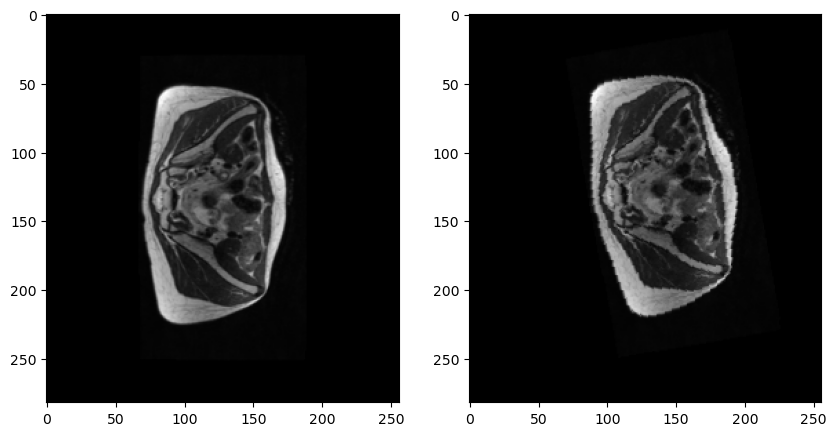

In [192]:
test_transform = transform_image([20,-10,10], axial_resampled_T2_cut_pad_norm_23)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(axial_resampled_T2_cut_pad_norm_23, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(test_transform, cmap='gray')


#### A test between two images that are a rigid transformation from one another

Iteration 0: Cost = 0.959271230509624, translation_params = [ 2.21705144 -0.80188035]
Iteration 10: Cost = 1.3058820171945422, translation_params = [18.37237523 -7.80678236]
STOP : Iteration 16: Cost = 1.3180605252418545, translation_params = [20.1876998  -8.07807172]
Iteration 0: Cost = 1.414245127196053, teta = 3.100834512294197
STOP : Iteration 4: Cost = 1.70248873271629, teta = 9.29088400499852
Iteration 0: Cost = 1.820633963093826, translation_params = [1.65449622 0.25747642]
Iteration 10: Cost = 2.076933812832398, translation_params = [1.27384315 0.65828499]
Iteration 20: Cost = 1.8810807055463359, translation_params = [1.73869964 1.78307589]
Iteration 30: Cost = 2.076933812832398, translation_params = [1.25719808 0.78399856]
Iteration 40: Cost = 2.076933812832398, translation_params = [1.49408351 1.19042509]
Iteration 50: Cost = 1.774016135778269, translation_params = [2.64342768 0.91569887]
Iteration 60: Cost = 1.611978536115048, translation_params = [-1.13901313  1.35004009]
I

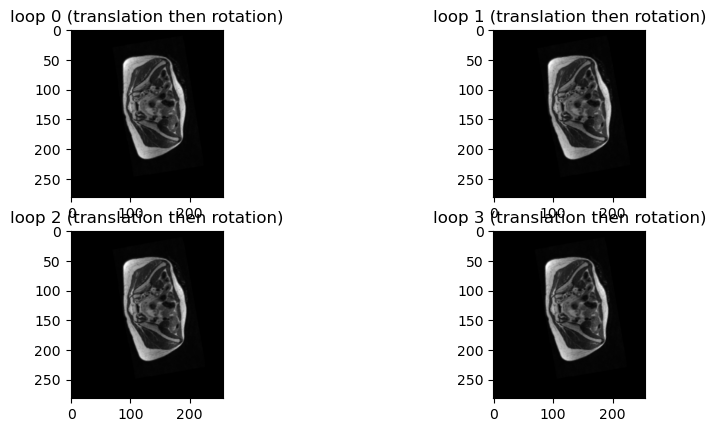

In [195]:
rows, cols = axial_resampled_T2_cut_pad_norm_23.shape
plt.figure(figsize = (10,10))

## Initial translation transformation paramters
initial_translation = np.array([0.,0.])
initial_teta = 0
semi_registered_img = axial_resampled_T2_cut_pad_norm_23.copy()
target_image = test_transform.copy()
optimized_params = np.identity(3)

for i in range(4) :
    ## Perform optimization on translation using gradient descent
    optimized_translation = gradient_descent_translation(cost_function_translation, gradient_translation, initial_translation, semi_registered_img, target_image)
    M1 = np.float32([[1, 0, optimized_translation[0]], [0, 1, optimized_translation[1]], [0, 0, 1]])
    optimized_params = np.matmul(M1, optimized_params)

    ## Perform optimization on rotation using gradient descent
    registered_img = transform_image_translation(optimized_translation, semi_registered_img)
    optimized_teta = gradient_descent_rotation(cost_function_rotation, gradient_rotation, initial_teta, registered_img, target_image, max_iters=101)
    M2 = cv2.getRotationMatrix2D((cols/2, rows/2), optimized_teta, 1)
    M2 = np.vstack((M2,[0,0,1]))
    optimized_params = np.matmul(M2, optimized_params)
    
    semi_registered_img = transform_image_rotation(optimized_teta, registered_img)
    
    M = optimized_params[:2,:]
    semi_result = cv2.warpAffine(axial_resampled_T2_cut_pad_norm_23, M, (cols, rows))
    plt.subplot(4,2,i+1)
    plt.imshow(semi_result, cmap='gray')
    plt.title(f'loop {i} (translation then rotation)')

In [196]:
print(f'obtained result :\n{M}\n')
theta_obt = np.rad2deg(np.arcsin(M[0,1]))
print(f'obtained theta : {theta_obt}')

rotation_matrix_for_theta = cv2.getRotationMatrix2D((cols/2, rows/2), theta_obt, 1)
print(f'\nrotation matrix for theta =\n{rotation_matrix_for_theta}\n')
print(f'dx = {M[0,2] - rotation_matrix_for_theta[0,2]}\tand dy = {M[1,2] - rotation_matrix_for_theta[1,2]}')

obtained result :
[[ 0.98545794  0.16991954 -2.43527877]
 [-0.16991954  0.98545794 13.85576915]]

obtained theta : 9.783140955967628

rotation matrix for theta =
[[  0.98545794   0.16991954 -22.09727131]
 [ -0.16991954   0.98545794  23.80013164]]

dx = 19.661992548043727	and dy = -9.944362489785984


#### Same algorithm but with b0 and T2

Iteration 0: Cost = 0.9020111339980543, translation_params = [-0.22630077  0.0474329 ]
Iteration 10: Cost = 0.9380822866912508, translation_params = [-2.58114824  0.55017161]
Iteration 20: Cost = 0.9681718816845679, translation_params = [-5.03818519  1.05509804]
Iteration 30: Cost = 1.0035882995456609, translation_params = [-7.43006837  1.57151293]
Iteration 40: Cost = 1.0380680955693435, translation_params = [-9.65107976  1.93044163]
Iteration 50: Cost = 1.0625316463264847, translation_params = [-11.5045848    2.17345089]
Iteration 60: Cost = 1.0778187228888303, translation_params = [-13.35502495   2.52883238]
Iteration 70: Cost = 1.1042804331622706, translation_params = [-15.20110307   2.86644588]
Iteration 80: Cost = 1.1295201482233734, translation_params = [-16.75200841   3.20885117]
Iteration 90: Cost = 1.1393290970190249, translation_params = [-17.88031431   3.47324497]
Iteration 0: Cost = 1.1459067242682988, teta = -0.5372215662593938
Iteration 10: Cost = 1.1642565291219267, tet

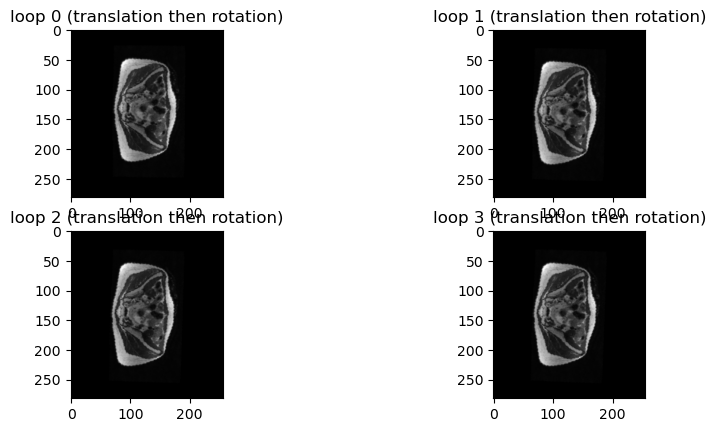

In [199]:
rows, cols = axial_resampled_T2_cut_pad_norm_23.shape
plt.figure(figsize = (10,10))

## Initial translation transformation paramters
initial_translation = np.array([0.,0.])
initial_teta = 0
semi_registered_img = test_transform.copy()
#semi_registered_img = axial_resampled_T2_cut_pad_norm_23.copy()
target_image = axial_b0_cut_pad_norm_23.copy()
optimized_params = np.identity(3)

for i in range(4) :
    ## Perform optimization on translation using gradient descent
    optimized_translation = gradient_descent_translation(cost_function_translation, gradient_translation, initial_translation, semi_registered_img, target_image)
    M1 = np.float32([[1, 0, optimized_translation[0]], [0, 1, optimized_translation[1]], [0, 0, 1]])
    optimized_params = np.matmul(optimized_params, M1)

    ## Perform optimization on rotation using gradient descent
    registered_img = transform_image_translation(optimized_translation, semi_registered_img)
    optimized_teta = gradient_descent_rotation(cost_function_rotation, gradient_rotation, initial_teta, registered_img, target_image, max_iters=101)
    M2 = cv2.getRotationMatrix2D((cols/2, rows/2), optimized_teta, 1)
    M2 = np.vstack((M2,[0,0,1]))
    optimized_params = np.matmul(optimized_params, M2)
    
    semi_registered_img = transform_image_rotation(optimized_teta, registered_img)
    
    M = optimized_params[:2,:]
    semi_result = cv2.warpAffine(test_transform, M, (cols, rows))
    plt.subplot(4,2,i+1)
    plt.imshow(semi_result, cmap='gray')
    plt.title(f'loop {i} (translation then rotation)')

In [200]:
print(f'obtained result :\n{M}\n')
theta_obt = np.rad2deg(np.arcsin(M[0,1]))
print(f'obtained theta : {theta_obt}')

rotation_matrix_for_theta = cv2.getRotationMatrix2D((cols/2, rows/2), theta_obt, 1)
print(f'\nrotation matrix for theta =\n{rotation_matrix_for_theta}\n')
print(f'dx = {M[0,2] - rotation_matrix_for_theta[0,2]}\tand dy = {M[1,2] - rotation_matrix_for_theta[1,2]}')

obtained result :
[[  0.9775716   -0.21060335   9.91719801]
 [  0.21060335   0.9775716  -14.50320855]]

obtained theta : -12.157712240120377

rotation matrix for theta =
[[  0.9775716   -0.21060335  32.56590728]
 [  0.21060335   0.9775716  -23.79482378]]

dx = -22.648709265297935	and dy = 9.291615234204508


#### Coherent results 

T2 sur b0 --> rotation de -2.30, dx de -0.23 et dy de -1.30

test_transform sur b0 --> rotation de -12.16 (-10 from test_transform to T2 and -2.3 from T2 to b0), dx de -22.65 et dy de 9.29 

#### Optimized test in a loop of 10 iterations to compute the best translation then the best rotation

Iteration 0: Cost = 1.0933436351058419, translation_params = [1. 1.]
Iteration 10: Cost = 1.1117582801991488, translation_params = [11.  9.]
Iteration 20: Cost = 1.1340582301996882, translation_params = [21. 14.]
Iteration 30: Cost = 1.1562705643591829, translation_params = [31. 16.]
Iteration 40: Cost = 1.1787662335392366, translation_params = [41. 17.]
STOP : Iteration 46: Cost = 1.1805769670467652, translation_params = [46. 17.]
Iteration 0: Cost = 1.1805769670467652, teta = 0.05602490610859823
Iteration 10: Cost = 1.1806562351722802, teta = 0.5677126158949397
Iteration 20: Cost = 1.1802890931257977, teta = 1.0312743758266696
Iteration 30: Cost = 1.1805246002595169, teta = 1.4551525519012398
Iteration 40: Cost = 1.1808934066502055, teta = 1.8214625068180834
Iteration 50: Cost = 1.1814550118294984, teta = 2.081538072923328
Iteration 60: Cost = 1.181525479707707, teta = 2.3309783041993914
Iteration 70: Cost = 1.1817563269162572, teta = 2.5362803889755225
Iteration 80: Cost = 1.1816122

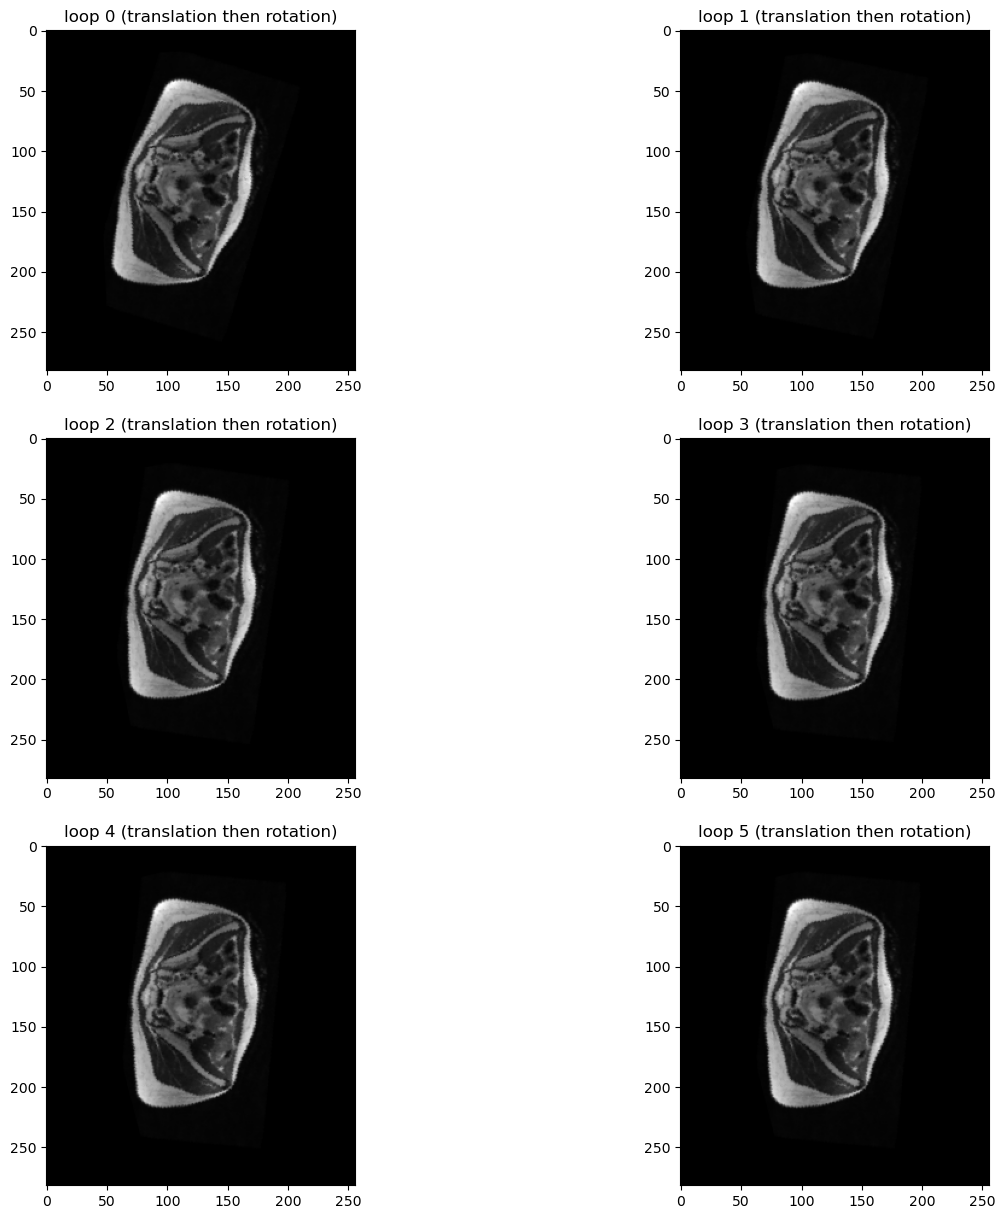

In [255]:
rows, cols = axial_resampled_T2_cut_pad_norm_23.shape
plt.figure(figsize = (15,15))

## Initial translation transformation paramters
initial_translation = np.array([0.,0.])
initial_teta = 0
#semi_registered_img = axial_resampled_T2_cut_pad_norm_23.copy()
semi_registered_img = test_transform.copy()
target_image = axial_b0_cut_pad_norm_23.copy()
optimized_params = np.identity(3)

for i in range(6) :
    ## Perform optimization on translation using gradient descent
    optimized_translation = gradient_descent_translation(cost_function_translation, gradient_translation, initial_translation, semi_registered_img, target_image)
    M1 = np.float32([[1, 0, optimized_translation[0]], [0, 1, optimized_translation[1]], [0, 0, 1]])
    optimized_params = np.matmul(M1, optimized_params)

    ## Perform optimization on rotation using gradient descent
    registered_img = transform_image_translation(optimized_translation, semi_registered_img)
    optimized_teta = gradient_descent_rotation(cost_function_rotation, gradient_rotation, initial_teta, registered_img, target_image)
    M2 = cv2.getRotationMatrix2D((cols/2, rows/2), optimized_teta, 1)
    M2 = np.vstack((M2,[0,0,1]))
    optimized_params = np.matmul(M2, optimized_params)
    
    semi_registered_img = transform_image_rotation(optimized_teta, registered_img)
    
    M = optimized_params[:2,:]
    #semi_result = cv2.warpAffine(axial_resampled_T2_cut_pad_norm_23, M, (cols, rows))
    semi_result = cv2.warpAffine(test_transform, M, (cols, rows))
    plt.subplot(3,2,i+1)
    plt.imshow(semi_result, cmap='gray')
    plt.title(f'loop {i} (translation then rotation)')

In [322]:
print(M)
print(np.arccos(M[0,0]))

[[ 1.  0. 71.]
 [ 0.  1.  0.]]
0.0


#### Verification that the cv2.warpAffine function is rotating the image from its center

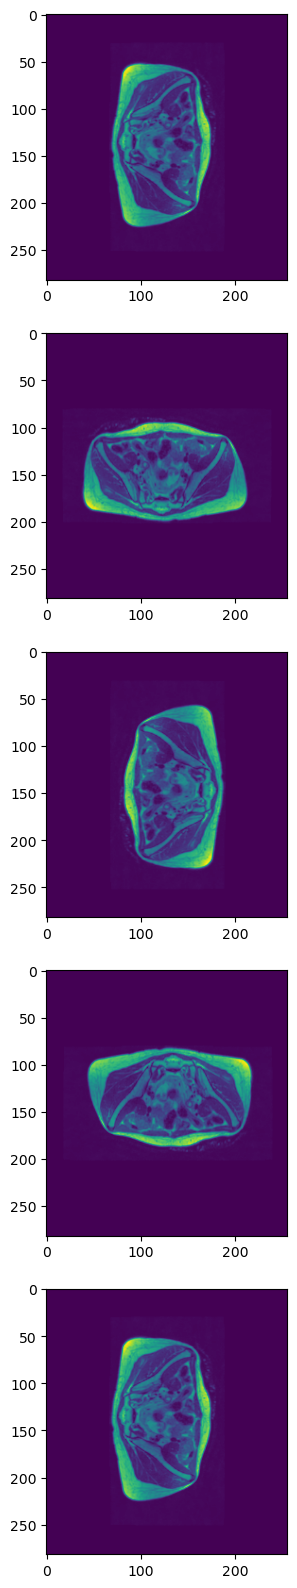

In [247]:
plt.figure(figsize=(15,20))
plt.subplot(5,1,1)
plt.imshow(axial_resampled_T2_cut_pad_norm_23)
plt.subplot(5,1,2)
test_transform_rotation = transform_image_rotation(90,axial_resampled_T2_cut_pad_norm_23)
plt.imshow(test_transform_rotation)
plt.subplot(5,1,3)
test_transform_rotation = transform_image_rotation(90,test_transform_rotation)
plt.imshow(test_transform_rotation)
plt.subplot(5,1,4)
test_transform_rotation = transform_image_rotation(90,test_transform_rotation)
plt.imshow(test_transform_rotation)
plt.subplot(5,1,5)
test_transform_rotation = transform_image_rotation(90,test_transform_rotation)
plt.imshow(test_transform_rotation)


# Results

In [233]:
def resampling_T2(voxel_size_T2, voxel_size_b0, img, verbose=0) :
    """ 
    Resample 'img' with voxel size of 'voxel_size_T2', to have voxel size of 'voxel_size_b0'
    """
    
    tmp = img.copy()
    
    xT2, yT2, zT2 = voxel_size_T2
    xb0, yb0, zb0 = voxel_size_b0
    
    scale_sagittal = xT2 / xb0
    scale_coronal = yT2 / yb0
    scale_axial = zT2 / zb0
    
    res = scipy.ndimage.zoom(tmp, (scale_sagittal, scale_coronal, scale_axial), order=1)
    
    if verbose > 0 :
        print(f'img size after re-sampling :{res.shape} voxels, {tuple(np.array(res.shape) * np.array(voxel_size_b0))} mm')

    return res

In [234]:
def resampling_affineT2(voxel_size_T2, voxel_size_b0, affineT2) :
    
    M = affineT2[0:3,0:3]
    T = affineT2[0:3,3]
    
    xT2, yT2, zT2 = voxel_size_T2
    xb0, yb0, zb0 = voxel_size_b0
    
    scale_sagittal = xT2 / xb0
    scale_coronal = yT2 / yb0
    scale_axial = zT2 / zb0
    
    zooming_matrix = [1./scale_sagittal, 1./scale_coronal, 1./scale_axial] * np.identity(3) 
    M = np.dot(M,zooming_matrix)

    affine_T2_resampled = np.zeros_like(affineT2)
    affine_T2_resampled[0:3,0:3] = M
    affine_T2_resampled[0:3,3] = T
    affine_T2_resampled[3,3] = 1
    
    return affine_T2_resampled

In [395]:
def cutting_to_ROI(T2, T2_mask, T2_seg, affineT2, b0, affineb0, verbose=0, useSeg=False, newMask=None) :
    
    if useSeg :
        z_min_T2, z_max_T2 = cut_T2_coro(T2, newMask, coordinates=True)
    else :
        z_min_T2, z_max_T2 = cut_T2_coro(T2, T2_mask, coordinates=True)
    
    T2_cut = T2[:,:,z_min_T2:z_max_T2]
    T2_mask_cut = T2_mask[:,:,z_min_T2:z_max_T2]    
    T2_seg_cut = T2_seg[:,:,z_min_T2:z_max_T2]   
    
    if verbose > 0 :
        print(f'Shape T2 before : {T2.shape}, and after : {T2_cut.shape}')
        #(_,_,z_min_RAS_T2,_) = np.dot(affineT2,(0, 0, 0,1))
        #(_,_,z_max_RAS_T2,_) = np.dot(affineT2,(0, 0, len(T2[0,0,:])-1,1))
        #print(f'z_min_RAS_T2 = {z_min_RAS_T2} and z_max_RAS_T2 = {z_max_RAS_T2}')
        
    ## transforming the voxel coordinates (T2) to RAS coordinates via affine matrix to have z_min and z_max (to cut coronal slices)
    (_,_,z_min_RAS,_) = np.dot(affineT2,(0, 0, z_min_T2,1))
    (_,_,z_max_RAS,_) = np.dot(affineT2,(0, 0, z_max_T2,1))

    ## transforming founded z_min and z_max RAS coordinates to voxel coordinates (b0) to cut coronal slices
    inverse_affineb0 = np.linalg.inv(affineb0)
    (_,_,z_min_b0,_) = np.dot(inverse_affineb0, (0,0,z_min_RAS,1))
    (_,_,z_max_b0,_) = np.dot(inverse_affineb0, (0,0,z_max_RAS,1))
    if verbose > 1 :
        print(z_min_b0, z_max_b0)
    z_min_b0 = int(np.rint(z_min_b0))
    z_max_b0 = int(np.rint(z_max_b0))

    b0_cut = b0[:,:,z_min_b0:z_max_b0]
    
    if verbose > 0 :
        print(f'Shape of b0 after: {b0_cut.shape}')
        #(_,_,z_min_RAS_b0,_) = np.dot(affineb0,(0, 0, 0,1))
        #(_,_,z_max_RAS_b0,_) = np.dot(affineb0,(0, 0, len(b0[0,0,:])-1,1))
        #print(f'z_min_RAS_b0 = {z_min_RAS_b0} and z_max_RAS_b0 = {z_max_RAS_b0}')
        #print(f'z_min_RAS_cut = {z_min_RAS}, z_max_RAS_cut = {z_max_RAS}')
        
    return T2_cut, T2_mask_cut, T2_seg_cut, b0_cut

In [252]:
def registration(img, target, translation, rotation, gdt, gdr, costT, costR, gradT, gradR, nbIter=4, verbose=0) :
    
    rows, cols = img.shape
    
    ## Initiation
    initial_translation = np.array([0.,0.])
    initial_teta = 0
    semi_registered_img = img.copy()
    target_image = target.copy()
    optimized_params = np.identity(3)

    
    for j in range(nbIter) :
        ## Perform optimization on translation using gradient descent
        optimized_translation = gdt(costT, gradT, initial_translation, semi_registered_img, target_image)
        M1 = np.float32([[1, 0, optimized_translation[0]], [0, 1, optimized_translation[1]], [0, 0, 1]])
        optimized_params = np.matmul(optimized_params, M1)

        ## Perform optimization on rotation using gradient descent
        registered_img = translation(optimized_translation, semi_registered_img)
        optimized_teta = gdr(costR, gradR, initial_teta, registered_img, target_image, max_iters=101)
        M2 = cv2.getRotationMatrix2D((cols/2, rows/2), optimized_teta, 1)
        M2 = np.vstack((M2,[0,0,1]))
        optimized_params = np.matmul(optimized_params, M2)

        semi_registered_img = rotation(optimized_teta, registered_img)

        M = optimized_params[:2,:]
        
        if verbose > 0 :
            semi_result = cv2.warpAffine(test_transform, M, (cols, rows))
            plt.figure()
            plt.imshow(semi_result, cmap='gray')
            plt.title(f'Loop {i} (translation then rotation)')
            plt.show()
            
        return M

## minor difficulty

In [437]:
## load images : b0, T2, mask_T2 and segmentation T2
minor_b0, affine_b0 = load_nii('minor', '1-2-14_off_210111', '1-2-14_off_210111_b0DWI.nii')
minor_T2, affine_T2 = load_nii('minor', '1-2-14_off_210111', '1-2-14_off_210111_coroT2Cube.nii')
minor_T2_mask, affine_T2_mask = load_nii('minor', '1-2-14_off_210111', '1-2-14_off_210111_T2Mask.nii')
minor_Segmentation_T2, affine_T2_seg = load_nii('minor', '1-2-14_off_210111', '1-2-14_off_210111_Segmentation.nii')

print(minor_T2.shape)

(400, 179, 400)


In [438]:
## voxel size T2 : 0.88 mm x 0.85 mm x 0.88 mm
## voxel size b0 : 1.25 mm x 1.25 mm x 3.5 mm

resampled_T2 = resampling_T2((0.88, 0.85, 0.88), (1.25, 1.25, 3.5), minor_T2, verbose=1)
resampled_T2_mask = resampling_T2((0.88, 0.85, 0.88), (1.25, 1.25, 3.5), minor_T2_mask)
resampled_T2_seg = resampling_T2((0.88, 0.85, 0.88), (1.25, 1.25, 3.5), minor_Segmentation_T2)
print(f'b0 size : {minor_b0.shape} voxels, {tuple(np.array(minor_b0.shape) * [1.25, 1.25, 3.5])} mm')

affine_T2_resampled = resampling_affineT2((0.88, 0.85, 0.88), (1.25, 1.25, 3.5), affine_T2)


img size after re-sampling :(282, 122, 101) voxels, (352.5, 152.5, 353.5) mm
b0 size : (256, 256, 75) voxels, (320.0, 320.0, 262.5) mm


In [439]:
## cutting T2 (and mask and seg) and b0 to find region of interest 

minor_T2_rs_cut, minor_T2_mask_rs_cut, minor_T2_seg_rs_cut, minor_b0_cut = cutting_to_ROI(resampled_T2, resampled_T2_mask, resampled_T2_seg, affine_T2_resampled, minor_b0, 
                                                                                 affine_b0, verbose=1)

Shape T2 before : (282, 122, 101), and after : (282, 122, 52)
Shape of b0 after: (256, 256, 52)


In [441]:
nums = np.arange(0,52,1)

liste_M = []

#plt.figure(figsize=(30,20))

for i in range(len(nums)) :
    num = nums[i]
    
    minor_b0_cut_axial_i = minor_b0_cut[:,:,num]
    minor_T2_rs_cut_axial_i = minor_T2_rs_cut[:,:,num]
    
    minor_T2_rs_cut_pad_axial_i, minor_b0_cut_pad_axial_i = padding(minor_T2_rs_cut_axial_i, minor_b0_cut_axial_i)
    
    minor_T2_rs_cut_pad_norm_axial_i = cv2.normalize(minor_T2_rs_cut_pad_axial_i, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    minor_b0_cut_pad_norm_axial_i = cv2.normalize(minor_b0_cut_pad_axial_i, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    M = registration(minor_T2_rs_cut_pad_norm_axial_i, minor_b0_cut_pad_norm_axial_i, transform_image_translation, transform_image_rotation,
                    gradient_descent_translation, gradient_descent_rotation, cost_function_translation, cost_function_rotation, 
                    gradient_translation, gradient_rotation, nbIter=4)
    
    liste_M.append(M)
    
    #print(f'obtained result :\n{M}\n')
    #theta_obt = np.rad2deg(np.arcsin(M[0,1]))
    #print(f'obtained theta : {theta_obt}')

    #rotation_matrix_for_theta = cv2.getRotationMatrix2D((cols/2, rows/2), theta_obt, 1)
    #print(f'\nrotation matrix for theta =\n{rotation_matrix_for_theta}\n')
    #print(f'dx = {M[0,2] - rotation_matrix_for_theta[0,2]}\tand dy = {M[1,2] - rotation_matrix_for_theta[1,2]}\n\n\n')


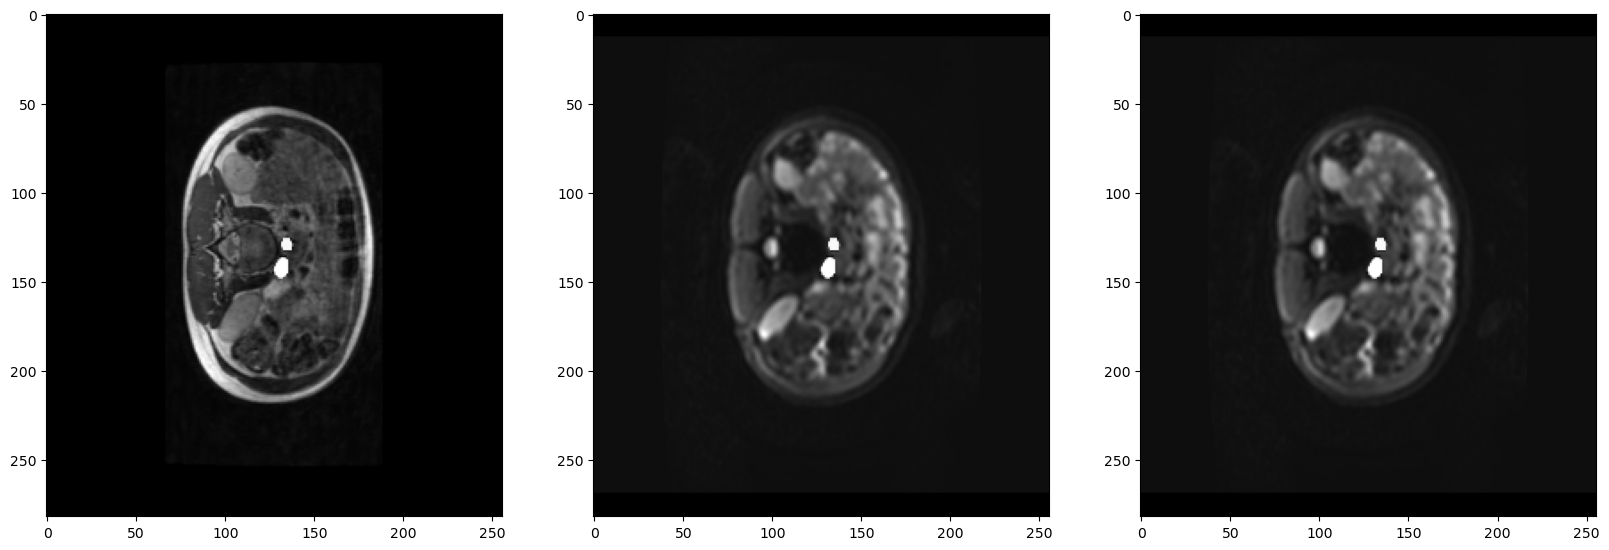

In [442]:
### plot seg on b0 before and after registration
minor_T2_seg_rs_cut_51 = minor_T2_seg_rs_cut[:,:,51]

minor_T2_seg_rs_cut_pad_51, minor_b0_cut_pad_axial_i = padding(minor_T2_seg_rs_cut_51, minor_b0_cut_axial_i)

minor_T2_seg_rs_cut_pad_norm_51 = cv2.normalize(minor_T2_seg_rs_cut_pad_51, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)


rows, cols = minor_T2_seg_rs_cut_pad_norm_51.shape

plt.figure(figsize=(20,40))
plt.subplot(1,3,1)
img3 = np.where(minor_T2_seg_rs_cut_pad_norm_51!=0, minor_T2_seg_rs_cut_pad_norm_51, minor_T2_rs_cut_pad_norm_axial_i)
plt.imshow(img3, cmap='gray')
#plt.imshow(minor_b0_cut_pad_norm_axial_i, cmap='gray')

plt.subplot(1,3,2)
img1 = np.where(minor_T2_seg_rs_cut_pad_norm_51!=0, minor_T2_seg_rs_cut_pad_norm_51, minor_b0_cut_pad_norm_axial_i)
plt.imshow(img1, cmap='gray')

plt.subplot(1,3,3)
reg_seg_T2 = cv2.warpAffine(minor_T2_seg_rs_cut_pad_norm_51, M, (cols, rows))
img2 = np.where(reg_seg_T2!=0, reg_seg_T2, minor_b0_cut_pad_norm_axial_i)
plt.imshow(img2, cmap='gray')


(-1.7763568394002505e-15, 1.7763568394002505e-15)

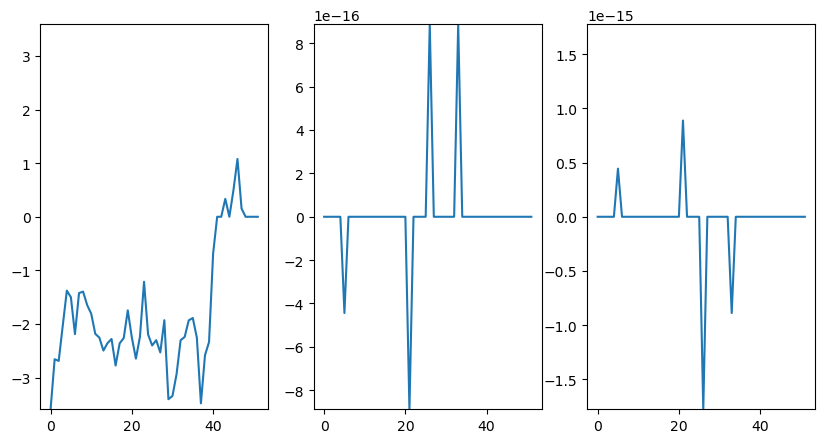

In [443]:
liste_theta = []
liste_dx = []
liste_dy = []

for i in range(len(liste_M)) :
    M = liste_M[i]
    theta_obt = np.rad2deg(np.arcsin(M[0,1]))
    liste_theta.append(theta_obt)

    rotation_matrix_for_theta = cv2.getRotationMatrix2D((cols/2, rows/2), theta_obt, 1)
    dx = M[0,2] - rotation_matrix_for_theta[0,2]
    dy = M[1,2] - rotation_matrix_for_theta[1,2]
    liste_dx.append(dx)
    liste_dy.append(dy)    
    
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.plot(nums, liste_theta)
y_max1 = abs(max(liste_theta, key=abs))
plt.ylim([-y_max1,y_max1])

plt.subplot(1,3,2)
plt.plot(nums, liste_dx)
y_max2 = abs(max(liste_dx, key=abs))
plt.ylim([-y_max2,y_max2])

plt.subplot(1,3,3)
plt.plot(nums, liste_dy)
y_max3 = abs(max(liste_dy, key=abs))
plt.ylim([-y_max3,y_max3])

## Minor difficulty, example 2

In [451]:
## load images : b0, T2, mask_T2 and segmentation T2
minorbis_b0, minorbis_affine_b0 = load_nii('minor', '1-2-15_off_210322', '1-2-15_off_210322_b0DWI.nii')
minorbis_T2, minorbis_affine_T2 = load_nii('minor', '1-2-15_off_210322', '1-2-15_off_210322_coroT2Cube.nii')
minorbis_T2_mask, minorbis_affine_T2_mask = load_nii('minor', '1-2-15_off_210322', '1-2-15_off_210322_T2Mask.nii')
minorbis_Segmentation_T2, minorbis_affine_T2_seg = load_nii('minor', '1-2-15_off_210322', '1-2-15_off_210322_Segmentation.nii')

print(minorbis_T2.shape)
print(minorbis_b0.shape)

(250, 117, 250)
(256, 256, 73)


In [452]:
## voxel size T2 : 0.88 mm x 0.85 mm x 0.88 mm
## voxel size b0 : 0.938 mm x 0.938 mm x 3.6 mm

print(f'T2 size before : {minorbis_T2.shape} voxels, {tuple(np.array(minorbis_T2.shape) * [0.88, 0.85, 0.88])} mm')
minorbis_resampled_T2 = resampling_T2((0.88, 0.85, 0.88), (0.938, 0.938, 3.6), minorbis_T2, verbose=1)
minorbis_resampled_T2_mask = resampling_T2((0.88, 0.85, 0.88), (0.938, 0.938, 3.6), minorbis_T2_mask)
minorbis_resampled_T2_seg = resampling_T2((0.88, 0.85, 0.88), (0.938, 0.938, 3.6), minorbis_Segmentation_T2)
print(f'b0 size : {minorbis_b0.shape} voxels, {tuple(np.array(minorbis_b0.shape) * [0.938, 0.938, 3.6])} mm')

minorbis_affine_T2_resampled = resampling_affineT2((0.88, 0.85, 0.88), (0.938, 0.938, 3.6), affine_minorbis_T2)


T2 size before : (250, 117, 250) voxels, (220.0, 99.45, 220.0) mm
img size after re-sampling :(235, 106, 61) voxels, (220.42999999999998, 99.428, 219.6) mm
b0 size : (256, 256, 73) voxels, (240.128, 240.128, 262.8) mm


In [454]:
## we can't cut like before because the mask is of same size as T2 which is bigger than b0
## --> se baser sur la segmentation plutôt que sur le mask ?

new_mask = np.where(minorbis_resampled_T2_seg==0.0, 0.0, 1.0)

minorbis_T2_rs_cut, minorbis_T2_mask_rs_cut, minorbis_T2_seg_rs_cut, minorbis_b0_cut = cutting_to_ROI(minorbis_resampled_T2, minorbis_resampled_T2_mask, minorbis_resampled_T2_seg, 
                                                                                          minorbis_affine_T2_resampled, minorbis_b0, 
                                                                                          minorbis_affine_b0, verbose=1, useSeg=True, newMask=new_mask) 

Shape T2 before : (235, 106, 61), and after : (235, 106, 40)
Shape of b0 after: (256, 256, 40)


In [464]:
nums = np.arange(5,26,5)

liste_M = []

#plt.figure(figsize=(30,20))

for i in range(len(nums)) :
    num = nums[i]
    
    minorbis_b0_cut_axial_i = minorbis_b0_cut[:,:,num]
    minorbis_T2_rs_cut_axial_i = minorbis_T2_rs_cut[:,:,num]
    
    minorbis_T2_rs_cut_pad_axial_i, minorbis_b0_cut_pad_axial_i = padding(minorbis_T2_rs_cut_axial_i, minorbis_b0_cut_axial_i)
    
    minorbis_T2_rs_cut_pad_norm_axial_i = cv2.normalize(minorbis_T2_rs_cut_pad_axial_i, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    minorbis_b0_cut_pad_norm_axial_i = cv2.normalize(minorbis_b0_cut_pad_axial_i, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    M = registration(minorbis_T2_rs_cut_pad_norm_axial_i, minorbis_b0_cut_pad_norm_axial_i, transform_image_translation, transform_image_rotation,
                    gradient_descent_translation, gradient_descent_rotation, cost_function_translation, cost_function_rotation, 
                    gradient_translation, gradient_rotation, nbIter=4)
    
    liste_M.append(M)
    
    #print(f'obtained result :\n{M}\n')
    #theta_obt = np.rad2deg(np.arcsin(M[0,1]))
    #print(f'obtained theta : {theta_obt}')

    #rotation_matrix_for_theta = cv2.getRotationMatrix2D((cols/2, rows/2), theta_obt, 1)
    #print(f'\nrotation matrix for theta =\n{rotation_matrix_for_theta}\n')
    #print(f'dx = {M[0,2] - rotation_matrix_for_theta[0,2]}\tand dy = {M[1,2] - rotation_matrix_for_theta[1,2]}\n\n\n')


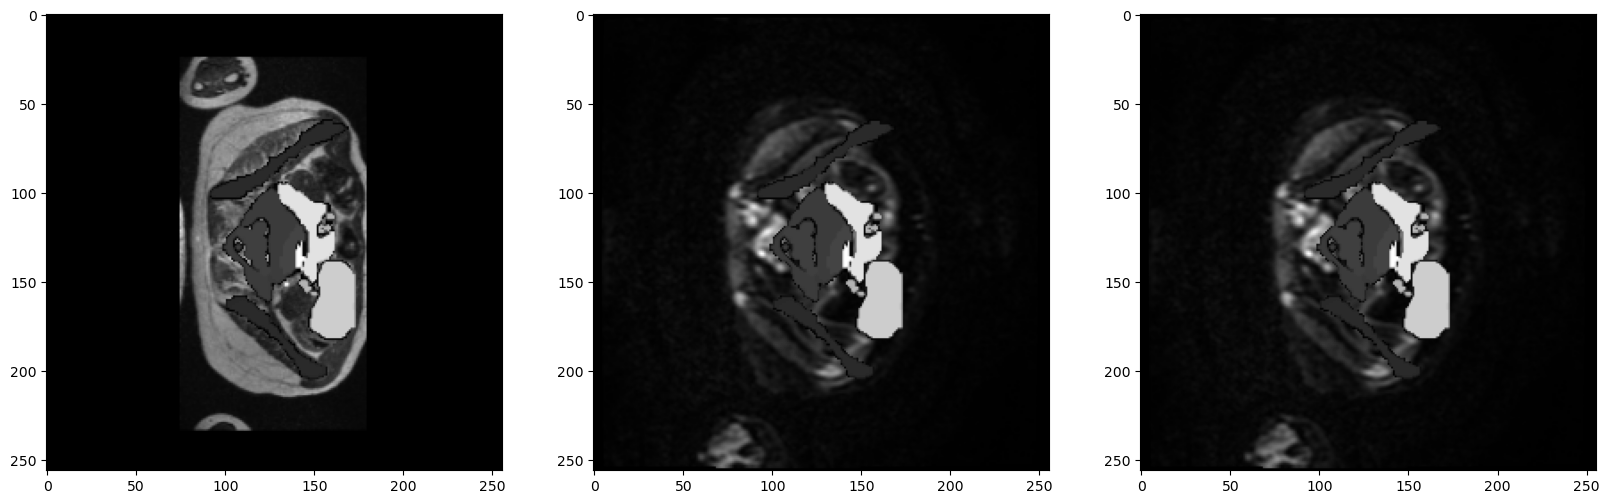

In [467]:
### plot seg on b0 before and after registration
minorbis_T2_seg_rs_cut_n = minorbis_T2_seg_rs_cut[:,:,25]

minorbis_T2_seg_rs_cut_pad_n, minorbis_b0_cut_pad_axial_i = padding(minorbis_T2_seg_rs_cut_n, minorbis_b0_cut_axial_i)

minorbis_T2_seg_rs_cut_pad_norm_n = cv2.normalize(minorbis_T2_seg_rs_cut_pad_n, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)


rows, cols = minorbis_T2_seg_rs_cut_pad_norm_n.shape

plt.figure(figsize=(20,15))
plt.subplot(1,3,1)
img3 = np.where(minorbis_T2_seg_rs_cut_pad_norm_n!=0, minorbis_T2_seg_rs_cut_pad_norm_n, minorbis_T2_rs_cut_pad_norm_axial_i)
plt.imshow(img3, cmap='gray')
#plt.imshow(minor_b0_cut_pad_norm_axial_i, cmap='gray')

plt.subplot(1,3,2)
img1 = np.where(minorbis_T2_seg_rs_cut_pad_norm_n!=0, minorbis_T2_seg_rs_cut_pad_norm_n, minorbis_b0_cut_pad_norm_axial_i)
plt.imshow(img1, cmap='gray')

plt.subplot(1,3,3)
reg_seg_T2 = cv2.warpAffine(minorbis_T2_seg_rs_cut_pad_norm_n, M, (cols, rows))
img2 = np.where(reg_seg_T2!=0, reg_seg_T2, minorbis_b0_cut_pad_norm_axial_i)
plt.imshow(img2, cmap='gray')

(-1.366027291411195e-31, 1.366027291411195e-31)

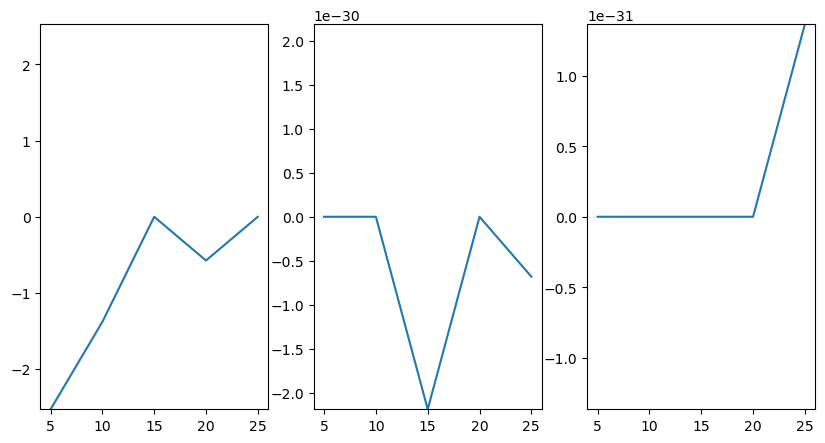

In [468]:
liste_theta = []
liste_dx = []
liste_dy = []

for i in range(len(liste_M)) :
    M = liste_M[i]
    theta_obt = np.rad2deg(np.arcsin(M[0,1]))
    liste_theta.append(theta_obt)

    rotation_matrix_for_theta = cv2.getRotationMatrix2D((cols/2, rows/2), theta_obt, 1)
    dx = M[0,2] - rotation_matrix_for_theta[0,2]
    dy = M[1,2] - rotation_matrix_for_theta[1,2]
    liste_dx.append(dx)
    liste_dy.append(dy)    
    
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.plot(nums, liste_theta)
y_max1 = abs(max(liste_theta, key=abs))
plt.ylim([-y_max1,y_max1])

plt.subplot(1,3,2)
plt.plot(nums, liste_dx)
y_max2 = abs(max(liste_dx, key=abs))
plt.ylim([-y_max2,y_max2])

plt.subplot(1,3,3)
plt.plot(nums, liste_dy)
y_max3 = abs(max(liste_dy, key=abs))
plt.ylim([-y_max3,y_max3])

## Minor difficulty, example 3

In [444]:
## load images : b0, T2, mask_T2 and segmentation T2
minorbis_b0, affine_minorbis_b0 = load_nii('minor', '1-2-61_200629', '1-2-61_200629_b0DWI.nii')
minorbis_T2, affine_minorbis_T2 = load_nii('minor', '1-2-61_200629', '1-2-61_200629_coroT2Cube.nii')
minorbis_T2_mask, affine_minorbis_T2_mask = load_nii('minor', '1-2-61_200629', '1-2-61_200629_T2Mask.nii')
minorbis_Segmentation_T2, affine_minorbis_T2_seg = load_nii('minor', '1-2-61_200629', '1-2-61_200629_Segmentation.nii')

print(minor_T2.shape)

(400, 179, 400)


In [445]:
## voxel size T2 : 0.688 mm x 1 mm x 0.688 mm
## voxel size b0 : 1.25 mm x 3.5 mm x 1.25 mm

print(f'T2 size before : {minorbis_T2.shape} voxels, {tuple(np.array(minorbis_T2.shape) * [0.688, 1.0, 0.688])} mm')
resampled_T2 = resampling_T2((0.688, 1.0, 0.688), (1.25, 3.5, 1.25), minorbis_T2, verbose=1)
resampled_T2_mask = resampling_T2((0.688, 1.0, 0.688), (1.25, 3.5, 1.25), minorbis_T2_mask)
resampled_T2_seg = resampling_T2((0.688, 1.0, 0.688), (1.25, 3.5, 1.25), minorbis_Segmentation_T2)
print(f'b0 size : {minorbis_b0.shape} voxels, {tuple(np.array(minorbis_b0.shape) * [1.25, 3.5, 1.25])} mm')

affine_T2_resampled = resampling_affineT2((0.688, 1.0, 0.688), (1.25, 3.5, 1.25), affine_minorbis_T2)

T2 size before : (512, 156, 512) voxels, (352.256, 156.0, 352.256) mm
img size after re-sampling :(282, 45, 282) voxels, (352.5, 157.5, 352.5) mm
b0 size : (256, 46, 256) voxels, (320.0, 161.0, 320.0) mm


In [446]:
## we can't cut like before because the mask is of same size as T2 which is bigger than b0
## --> se baser sur la segmentation plutôt que sur le mask ?

new_mask = np.where(resampled_T2_seg==0.0, 0.0, 1.0)

minor_T2_rs_cut, minor_T2_mask_rs_cut, minor_T2_seg_rs_cut, minor_b0_cut = cutting_to_ROI(resampled_T2, resampled_T2_mask, resampled_T2_seg, affine_T2_resampled, minorbis_b0, 
                                                                                          affine_minorbis_b0, verbose=2, useSeg=True, newMask=new_mask) 
minor_b0_cut = np.dstack((minor_b0_cut, minorbis_b0[:,:,235]))
print(minor_b0_cut.shape)

Shape T2 before : (282, 45, 282), and after : (282, 45, 149)
85.7241134707173 234.46350668627343
Shape of b0 after: (256, 46, 148)
(256, 46, 149)


In [406]:
nums = np.arange(5,76,10)

liste_M = []

#plt.figure(figsize=(30,20))

for i in range(len(nums)) :
    num = nums[i]
    
    minor_b0_cut_axial_i = minor_b0_cut[:,:,num]
    minor_T2_rs_cut_axial_i = minor_T2_rs_cut[:,:,num]
    
    minor_T2_rs_cut_pad_axial_i, minor_b0_cut_pad_axial_i = padding(minor_T2_rs_cut_axial_i, minor_b0_cut_axial_i)
    
    minor_T2_rs_cut_pad_norm_axial_i = cv2.normalize(minor_T2_rs_cut_pad_axial_i, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    minor_b0_cut_pad_norm_axial_i = cv2.normalize(minor_b0_cut_pad_axial_i, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    M = registration(minor_T2_rs_cut_pad_norm_axial_i, minor_b0_cut_pad_norm_axial_i, transform_image_translation, transform_image_rotation,
                    gradient_descent_translation, gradient_descent_rotation, cost_function_translation, cost_function_rotation, 
                    gradient_translation, gradient_rotation, nbIter=4)
    
    liste_M.append(M)
    
    #print(f'obtained result :\n{M}\n')
    #theta_obt = np.rad2deg(np.arcsin(M[0,1]))
    #print(f'obtained theta : {theta_obt}')

    #rotation_matrix_for_theta = cv2.getRotationMatrix2D((cols/2, rows/2), theta_obt, 1)
    #print(f'\nrotation matrix for theta =\n{rotation_matrix_for_theta}\n')
    #print(f'dx = {M[0,2] - rotation_matrix_for_theta[0,2]}\tand dy = {M[1,2] - rotation_matrix_for_theta[1,2]}\n\n\n')


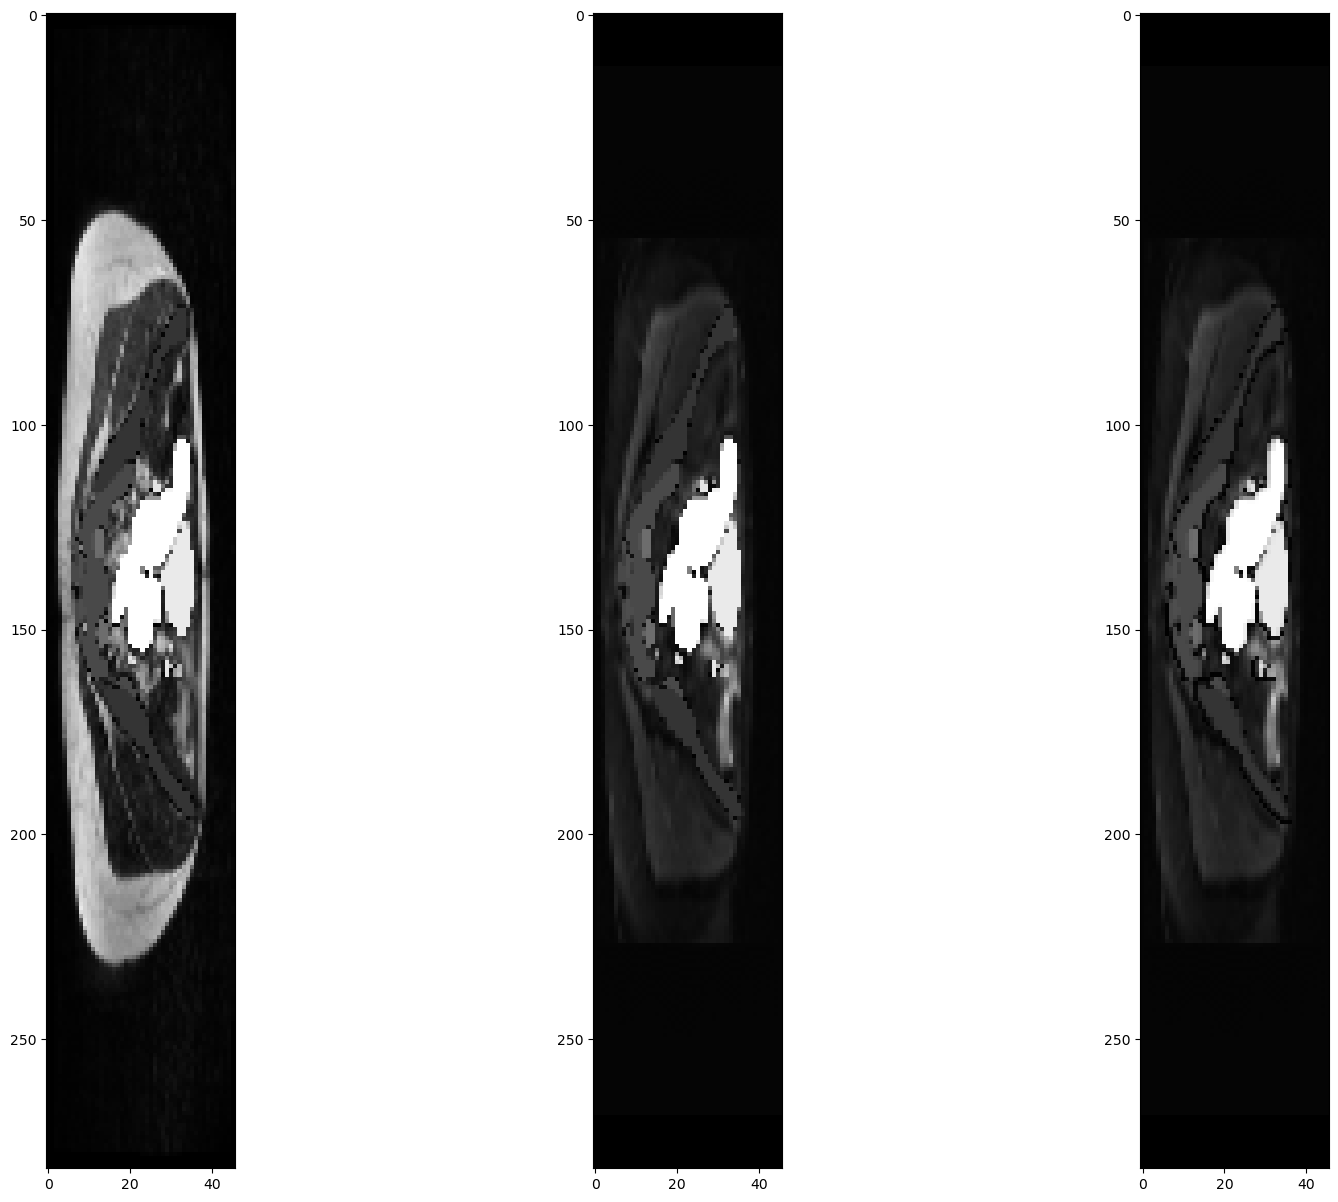

In [408]:
### plot seg on b0 before and after registration
minor_T2_seg_rs_cut_n = minor_T2_seg_rs_cut[:,:,75]

minor_T2_seg_rs_cut_pad_n, minor_b0_cut_pad_axial_i = padding(minor_T2_seg_rs_cut_n, minor_b0_cut_axial_i)

minor_T2_seg_rs_cut_pad_norm_n = cv2.normalize(minor_T2_seg_rs_cut_pad_n, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)


rows, cols = minor_T2_seg_rs_cut_pad_norm_n.shape

plt.figure(figsize=(20,15))
plt.subplot(1,3,1)
img3 = np.where(minor_T2_seg_rs_cut_pad_norm_n!=0, minor_T2_seg_rs_cut_pad_norm_n, minor_T2_rs_cut_pad_norm_axial_i)
plt.imshow(img3, cmap='gray')
#plt.imshow(minor_b0_cut_pad_norm_axial_i, cmap='gray')

plt.subplot(1,3,2)
img1 = np.where(minor_T2_seg_rs_cut_pad_norm_n!=0, minor_T2_seg_rs_cut_pad_norm_n, minor_b0_cut_pad_norm_axial_i)
plt.imshow(img1, cmap='gray')

plt.subplot(1,3,3)
reg_seg_T2 = cv2.warpAffine(minor_T2_seg_rs_cut_pad_norm_n, M, (cols, rows))
img2 = np.where(reg_seg_T2!=0, reg_seg_T2, minor_b0_cut_pad_norm_axial_i)
plt.imshow(img2, cmap='gray')

#

# Function for special examples

In [ ]:
def padding(img1, img2) :
    """
    Padding img1 and/or img2 to have same shape (object on the upper left)
    """
    
    tmp1 = img1.copy()
    tmp2 = img2.copy()
    h1, w1 = img1.shape
    h2, w2 = img2.shape
    pad_h = h2-h1
    pad_w = w2-w1
    
    
    if pad_h < 0 :
        ## h2 < h1
        tmp = np.vstack((tmp2, np.zeros((-pad_h,w2))))
            
        if pad_w < 0 :
            ## w2 < w1
            nv_img2 = np.hstack((tmp, np.zeros((h1,-pad_w))))
            return tmp1, nv_img2
        
        elif pad_w == 0 :
            return tmp1, tmp
        
        else :
            ## w2 > w1
            nv_img1 = np.hstack((tmp1, np.zeros((h1,pad_w))))
            return nv_img1, tmp
        
        
    elif pad_h == 0 :
        if pad_w < 0 :
            ## w2 < w1
            nv_img2 = np.hstack((tmp2, np.zeros((h2,-pad_w))))   
            return tmp1, nv_img2
        
        elif pad_w == 0 :
            return tmp1, tmp2
        
        else :
            ## w2 > w1
            nv_img1 = np.hstack((tmp1, np.zeros((h1,pad_w))))
            return nv_img1, tmp2
        
    else :
        ## h2 > h1
        tmp = np.vstack((tmp1, np.zeros(pad_h,w1)))
        
        if pad_w < 0 :
            ## w2 < w1
            nv_img2 = np.hstack((tmp2, np.zeros((h2,-pad_w))))
            return tmp, nv_img2
        
        elif pad_w == 0 :
            return tmp, tmp2
        
        else :
            ## w2 > w1
            nv_img1 = np.hstack((tmp1, np.zeros((h2, pad_w))))
            return nv_img1, tmp2

    

In [ ]:
# Define transformation function (cv2.warpAffine() implicitly uses linear interpolation)

def transform_image(params, img):
    rows, cols = img.shape
    dx, dy, theta = params
    #print(f'dx: {dx}, dy: {dy}, theta: {theta}')

    M = cv2.getRotationMatrix2D((cols/2, rows/2), theta, 1)
    M[0,2] += dx
    M[1,2] += dy
    M = np.vstack((M,[0,0,1]))
    M_inv = np.linalg.inv(M)[0:2,0:3]
    
    return cv2.warpAffine(img.copy(), M_inv, (cols, rows), flags= cv2.INTER_NEAREST + cv2.WARP_INVERSE_MAP)